In [1]:
import cartopy
from collections import defaultdict
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import sys

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.append("../src")
from installations.plot import plot_gantt, plot_durations
from marinetraffic.vesseltracks import read_vesseltracks_file
from marinetraffic.plot import plot_vesseltracks_cartopy
from metocean.era5 import weather_df_from_era5

plt.style.use('fivethirtyeight-paper')
print(mpl.rcParams['font.family'])
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
print(font)

installation_data_dir = "../data/windfarms/matching_windfarms//"

['sans-serif']
/home/san/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf


In [2]:
installations_metadata = pd.read_csv("../data/windfarms/matching_windfarms/matching_windfarms.csv")
windfarm_database = pd.read_excel("../data/windfarms/windfarms-complete_turbines.ods", engine="odf")
windfarm_database.set_index("index", inplace=True)
windfarm_database.sort_index(inplace=True)

In [3]:
windfarm_database.columns

Index(['name', 'latitude', 'longitude', 'n_turbines', 'turbine_power',
       'windfarm_capacity', 'turbine_installation_start',
       'turbine_installation_end', 'turbine_installation_vessel',
       'days_per_foundation_lit', 'days_per_turbine_lit', 'days_set_lit',
       'Source', 'Unnamed: 14', 'Unnamed: 15'],
      dtype='object')

In [4]:
installations = dict()
for infile in sorted(glob.glob(os.path.join(installation_data_dir, "*cluster-*.csv"))):
    installation_index = int(os.path.basename(infile).split("_")[0])
    vessel_name = installations_metadata.loc[installation_index].vessel_name
    windfarm_database_index = installations_metadata.loc[installation_index].known_windfarms_index
    windfarm = os.path.basename(infile).split("_")[1]
    installations[windfarm_database_index] = pd.read_csv(infile)
    installations[windfarm_database_index].begin = pd.to_datetime(installations[windfarm_database_index].begin)
    installations[windfarm_database_index].end = pd.to_datetime(installations[windfarm_database_index].end)
    installations[windfarm_database_index].insert(loc=0, column='vessel', value=[vessel_name]*len(installations[windfarm_database_index]))
    installations[windfarm_database_index].insert(loc=0, column='windfarm', value=[windfarm]*len(installations[windfarm_database_index]))
    installations[windfarm_database_index].sort_values('begin', inplace=True)
    installations[windfarm_database_index].set_index('index', inplace=True)
    installations[windfarm_database_index].reset_index(drop=True, inplace=True)

In [5]:
for i, (key, windfarm) in enumerate(installations.items()):
    print(i+1, windfarm_database.loc[key]['name'], len(windfarm))
    if len(windfarm) > (nd := windfarm_database.loc[key].n_turbines):
        print(f'oh oh: {len(windfarm)} > {nd}')

1 Luchterduinen 4
2 Westermost Rough 32
3 Arkona 49
4 East Anglia One 11
5 Dudgeon 61
6 Gode Wind I & II 61
7 Hornsea 100
8 Borssele I/II 55
9 Humber Gateway 83
oh oh: 83 > 73
10 Northwind 52
11 Deutsche Bucht 14
12 Veja Mate 19
13 Galloper 11
14 Global Tech I 22
15 Butendiek 76
16 Moray East 68
17 Borkum Riffgrund 2 48
18 Borkum Riﬀgat 20
19 Merkur 59
20 Trianel Borkum 2 9
21 Gemini 29
22 Albatros 11
23 Nobelwind 41
24 Kriegers Flak 72
25 Wikinger 64
26 Yunlin 11
27 Horns Rev 3 46
28 Sandbank 73
oh oh: 73 > 72
29 Teesside 25
30 Rampion 41
31 BARD Oﬀshore I 15
32 Northwester 2 41
oh oh: 41 > 23
33 EnBW Baltic II (MP) 42
oh oh: 42 > 39


In [6]:
def extract_farm_stats(installations, windfarm_database):
    for i, (key, windfarm) in enumerate(installations.items()):
        # 'latitude', 'longitude', 'n_turbines', 'turbine_power', 'windfarm_capacity',
        yield [
            windfarm_database.loc[key]['name'],
            int(windfarm_database.loc[key]['n_turbines']),
            windfarm_database.loc[key]['turbine_power'],
            windfarm_database.loc[key]['windfarm_capacity'],
            len(windfarm),
        ]
        

In [7]:
print(pd.DataFrame(
    data = extract_farm_stats(installations, windfarm_database), 
    columns = [
        "Wind Farm Name",
        "Number of Turbines",
        "Rated Turbine Power",
        "Wind Farm Capacity",
        "Number of Extracted Wind Turbines"
    ]).to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
     Wind Farm Name &  Number of Turbines &  Rated Turbine Power &  Wind Farm Capacity &  Number of Extracted Wind Turbines \\
\midrule
      Luchterduinen &                  43 &                 3.00 &              129.00 &                                  4 \\
   Westermost Rough &                  35 &                 6.00 &              210.00 &                                 32 \\
             Arkona &                  60 &                 6.42 &              385.00 &                                 49 \\
    East Anglia One &                 102 &                 7.00 &              714.00 &                                 11 \\
            Dudgeon &                  67 &                 6.00 &              402.00 &                                 61 \\
   Gode Wind I \& II &                  97 &                 6.00 &              582.00 &                                 61 \\
            Hornsea &                 174 &                 7.00 &   

/tmp/ipykernel_60594/2686027095.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(


In [30]:
pd.DataFrame(
    data = extract_farm_stats(installations, windfarm_database), 
    columns = [
        "Wind Farm Name",
        "Number of Turbines",
        "Rated Turbine Power",
        "Wind Farm Capacity",
        "Number of Extracted Wind Turbines"
    ]).to_latex("../manuscript/windfarms.txt", index=False, float_format="%.2f")

/tmp/ipykernel_60594/1493859540.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(


In [8]:
all_installations = pd.concat([installation for _, installation in installations.items()])
all_installations.sort_values("begin", inplace=True)
all_installations.reset_index(drop=True, inplace=True)
#all_installations.insert(loc = len(all_installations.columns), column = 'cumsum_duration', value = all_installations.duration.cumsum())
print(f"available turbine installations: {len(all_installations)}")

available turbine installations: 1365


# Material and Methods

## Wind Farm Clustering to Extract Single Turbines

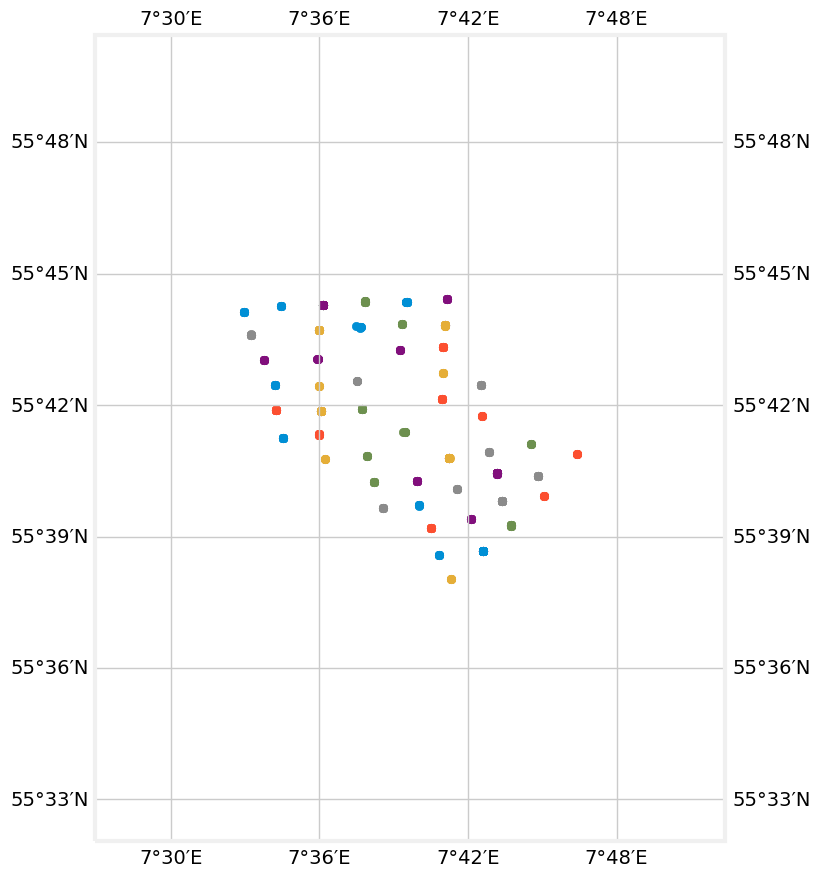

In [10]:
# exemplary data set: brave tern, cluster 10 (horns rev 3)
locations = dict()
for location in sorted(glob.glob(os.path.join("../data/marinetraffic/clustered/229044000-brave-tern/cluster-10/*location-*.csv"))):
    loc_key = location.split("_")[-1].split(".")[0]
    locations[loc_key] = read_vesseltracks_file(location)
    
n_locations = len(locations)
margin = 0.1

min_lat = min([x.latitude.min() for _, x in locations.items()]) - margin
max_lat = max([x.latitude.max() for _, x in locations.items()]) + margin
min_lon = min([x.longitude.min() for _, x in locations.items()]) - margin
max_lon = max([x.longitude.max() for _, x in locations.items()]) + margin

figure = plt.figure(figsize=(16,9))
ax = figure.add_subplot(1,1,1, projection=cartopy.crs.Mercator())
ax.set_extent([min_lon, max_lon, min_lat, max_lat])
ax.add_feature(cartopy.feature.BORDERS)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.coastlines(resolution='10m')
#plt.scatter(vessel_tracks['longitude'], vessel_tracks['latitude'], transform=cartopy.crs.PlateCarree())
color = cm.rainbow(np.linspace(0, 1, n_locations))
for c, (_, loc) in zip(color, locations.items()):
    plt.scatter(loc.longitude, loc.latitude, transform=cartopy.crs.PlateCarree())
plt.tight_layout()
plt.savefig("../manuscript/figures/horns-rev-3_turbines.png",dpi=300)
    

In [11]:
average_installation = all_installations.duration.mean()
median_installation = all_installations.duration.median()
std_installation = all_installations.duration.std()
print(f"average installation time: {average_installation} (median: {median_installation}) +- {std_installation}")

average installation time: 47.33259747659748 (median: 27.049722222222226) +- 58.36211200923583


In [12]:
np.percentile(all_installations.duration, 90)

99.32405555555589

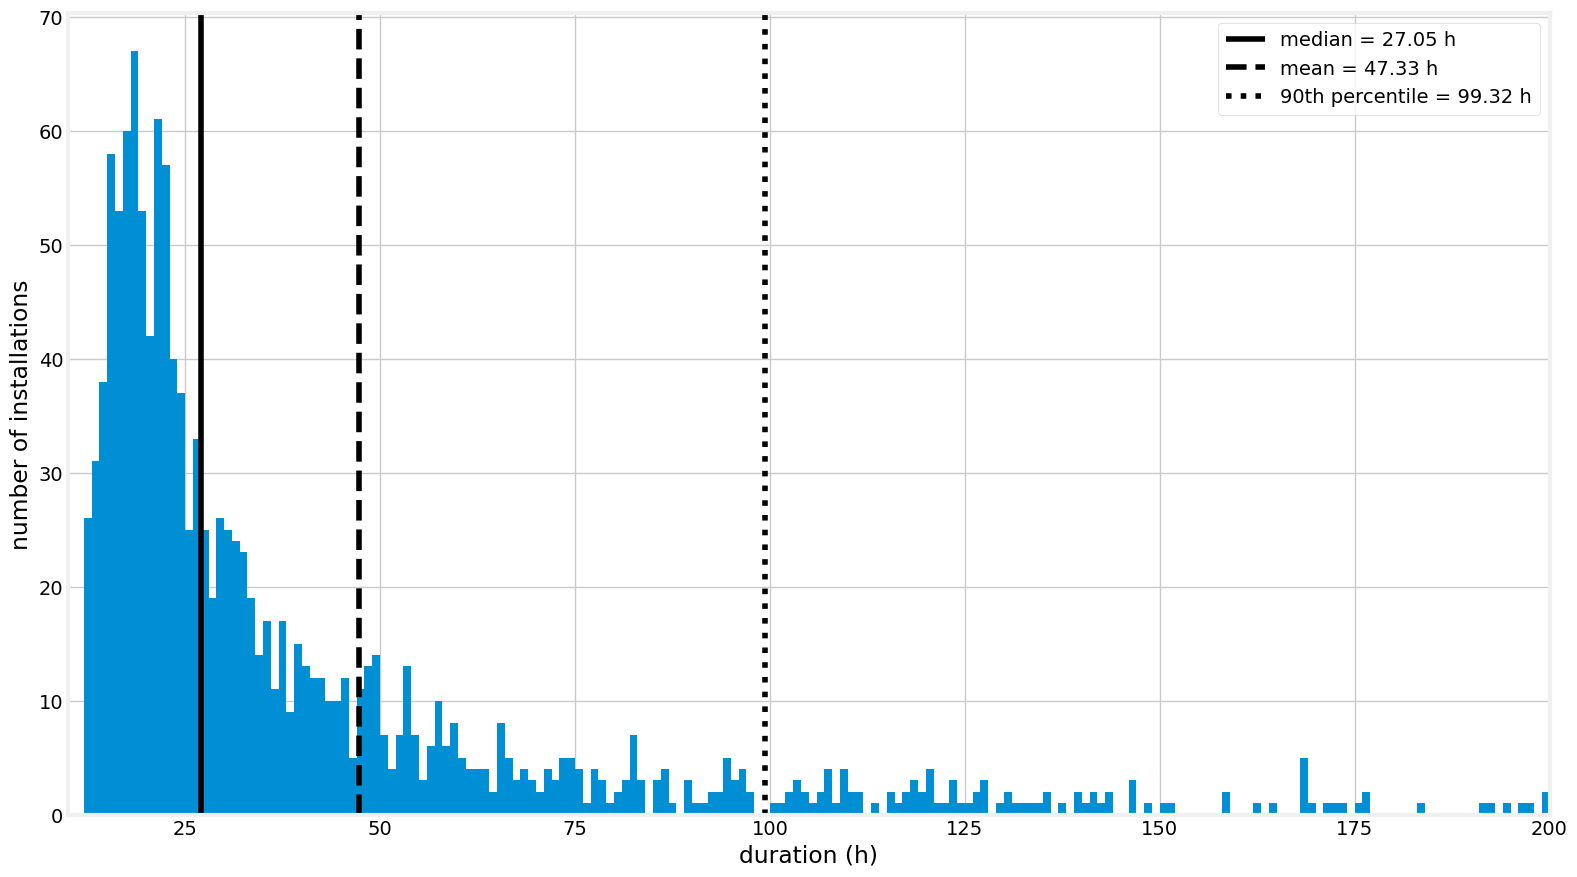

In [13]:
plt.figure(figsize=(16,9))
n, bins, patches = plt.hist(all_installations.duration, bins=[x for x in range(12, 720)])
plt.xlim([10, 200])
plt.xlabel("duration (h)")
plt.ylabel("number of installations")
plt.axvline(x = all_installations.duration.median(), label=f'median = {all_installations.duration.median():1.2f} h', color='k', linestyle='-')
plt.axvline(x = all_installations.duration.mean(), label=f'mean = {all_installations.duration.mean():1.2f} h', color='k', linestyle='--')
plt.axvline(x = np.percentile(all_installations.duration, 90), label=f'90th percentile = {np.percentile(all_installations.duration, 90):1.2f} h', color='k', linestyle='dotted')
plt.axvline()
plt.legend()
plt.tight_layout()
plt.savefig("../manuscript/figures/duration-distribution.png", dpi=300)

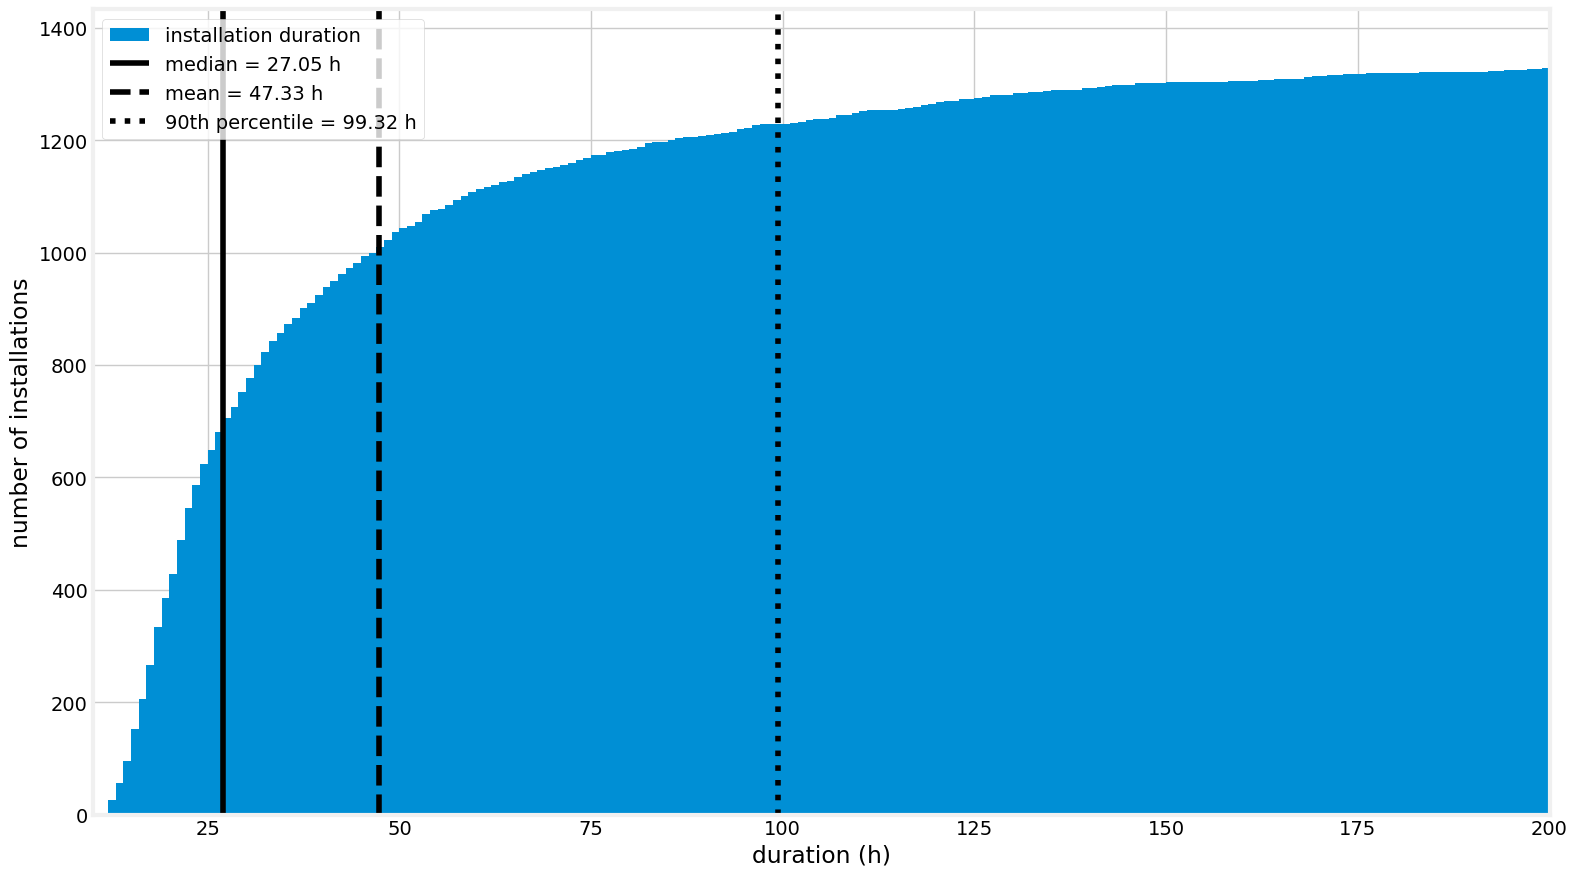

In [14]:
plt.figure(figsize=(16,9))
n, bins, patches = plt.hist(all_installations.duration, bins=[x for x in range(12, 720)], label='installation duration', cumulative=True)
plt.xlim([10, 200])
plt.xlabel("duration (h)")
plt.ylabel("number of installations")
plt.axvline(x = all_installations.duration.median(), label=f'median = {all_installations.duration.median():1.2f} h', color='k', linestyle='-')
plt.axvline(x = all_installations.duration.mean(), label=f'mean = {all_installations.duration.mean():1.2f} h', color='k', linestyle='--')
plt.axvline(x = np.percentile(all_installations.duration, 90), label=f'90th percentile = {np.percentile(all_installations.duration, 90):1.2f} h', color='k', linestyle='dotted')
plt.axvline()
plt.legend()
plt.tight_layout()
plt.savefig("../manuscript/figures/duration-cumulative-distribution.png", dpi=300)

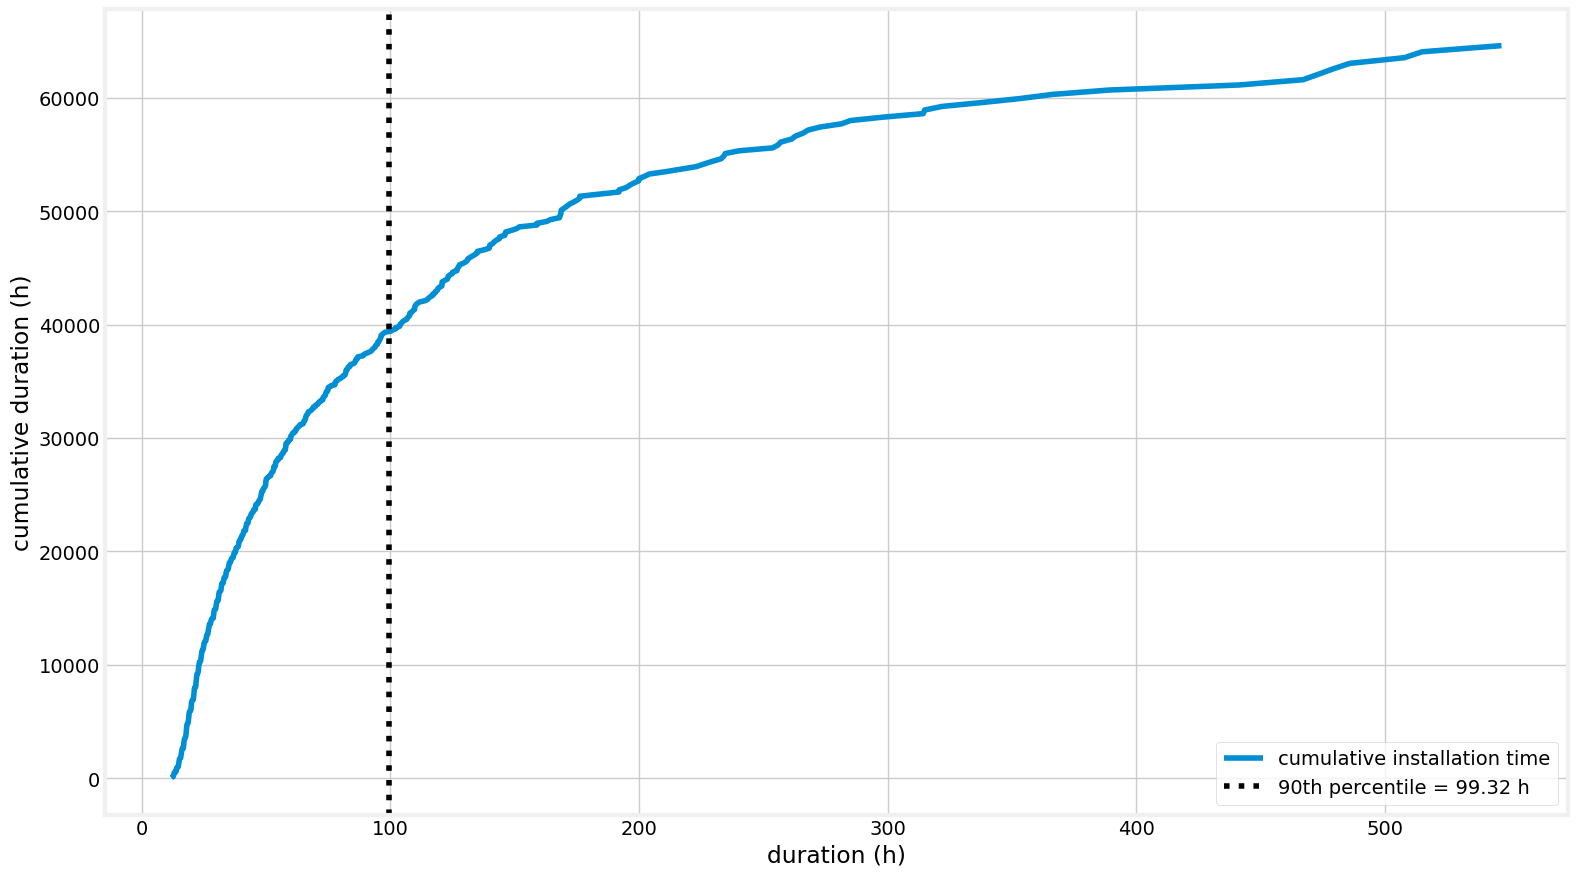

In [15]:
plt.figure(figsize=(16,9))
plt.plot(all_installations.sort_values('duration').duration, all_installations.sort_values('duration').duration.cumsum(), label='cumulative installation time')
plt.axvline(x = np.percentile(all_installations.duration, 90), label=f'90th percentile = {np.percentile(all_installations.duration, 90):1.2f} h', color='k', linestyle='dotted')
plt.xlabel("duration (h)")
plt.ylabel("cumulative duration (h)")
plt.legend()
plt.tight_layout()
plt.savefig("../manuscript/figures/cumulative-duration.png", dpi=300)

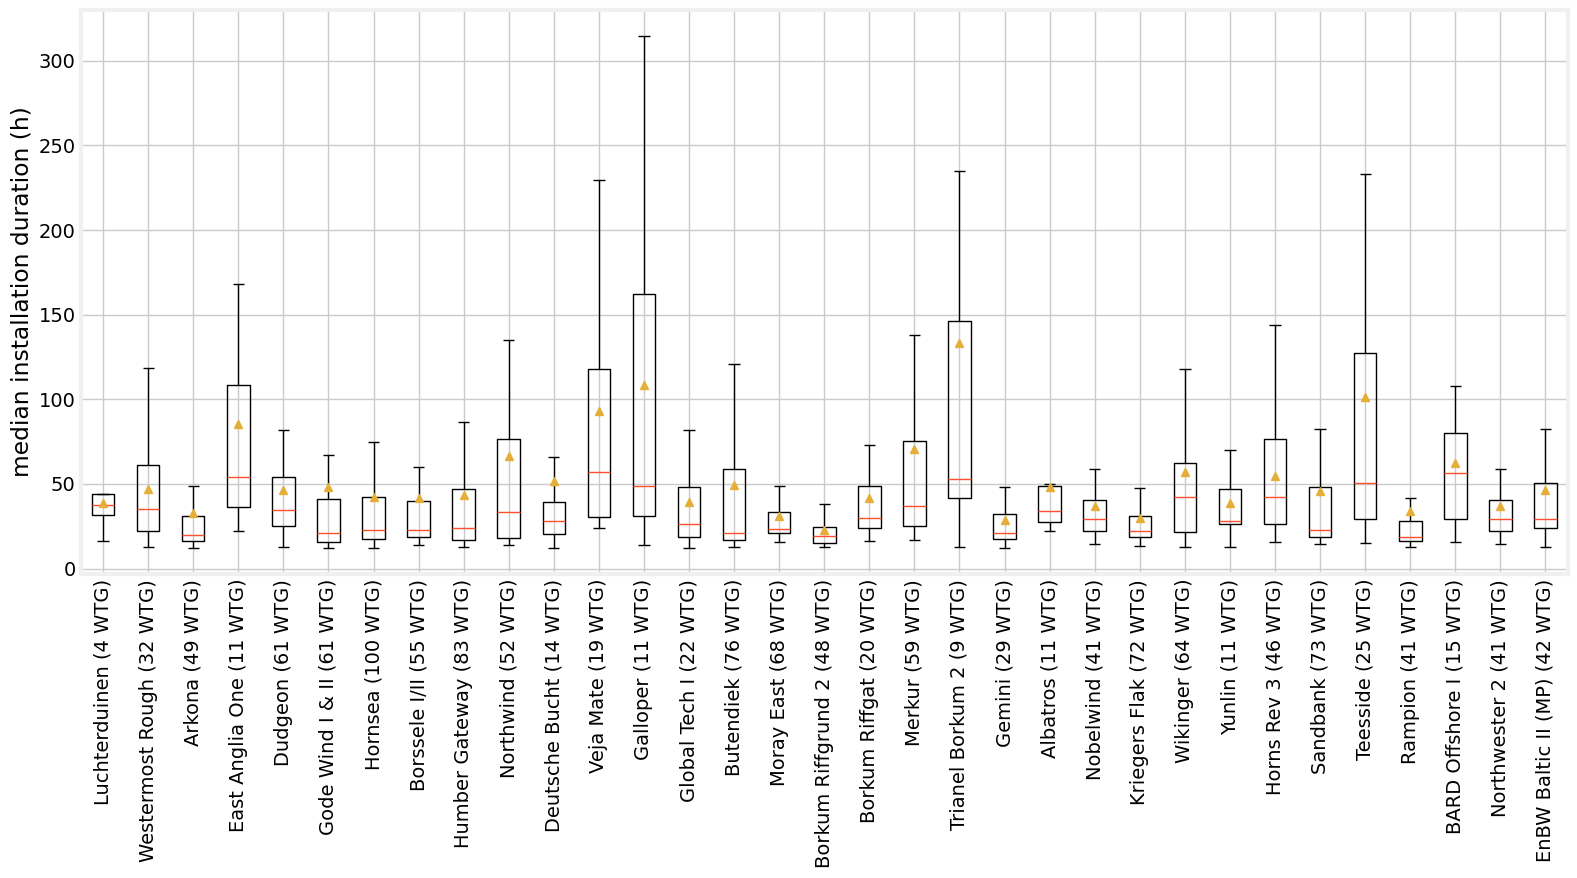

In [16]:
plt.figure(figsize=(16,9))
#p1 = plt.boxplot(
#    [x for x in range(len(installations))], 
#    [x.duration.median() for _, x in installations.items()],
#)
plt.boxplot([x.duration for x in installations.values()], showmeans=True, showfliers=False)
plt.xticks(
    [x + 1 for x in range(len(installations))],
    [ f"{windfarm_database.loc[i]['name']} ({len(y)} WTG)" for i, y in installations.items()],
    rotation=90
)
ax = plt.gca()
#ax.bar_label(p1, [ f"{windfarm_database.loc[i].turbine_power:1.1f}" for i, x in installations.items()], label_type='edge')
plt.ylabel("median installation duration (h)")
plt.tight_layout()
plt.savefig("../manuscript/figures/installations-overview.png", dpi=300)

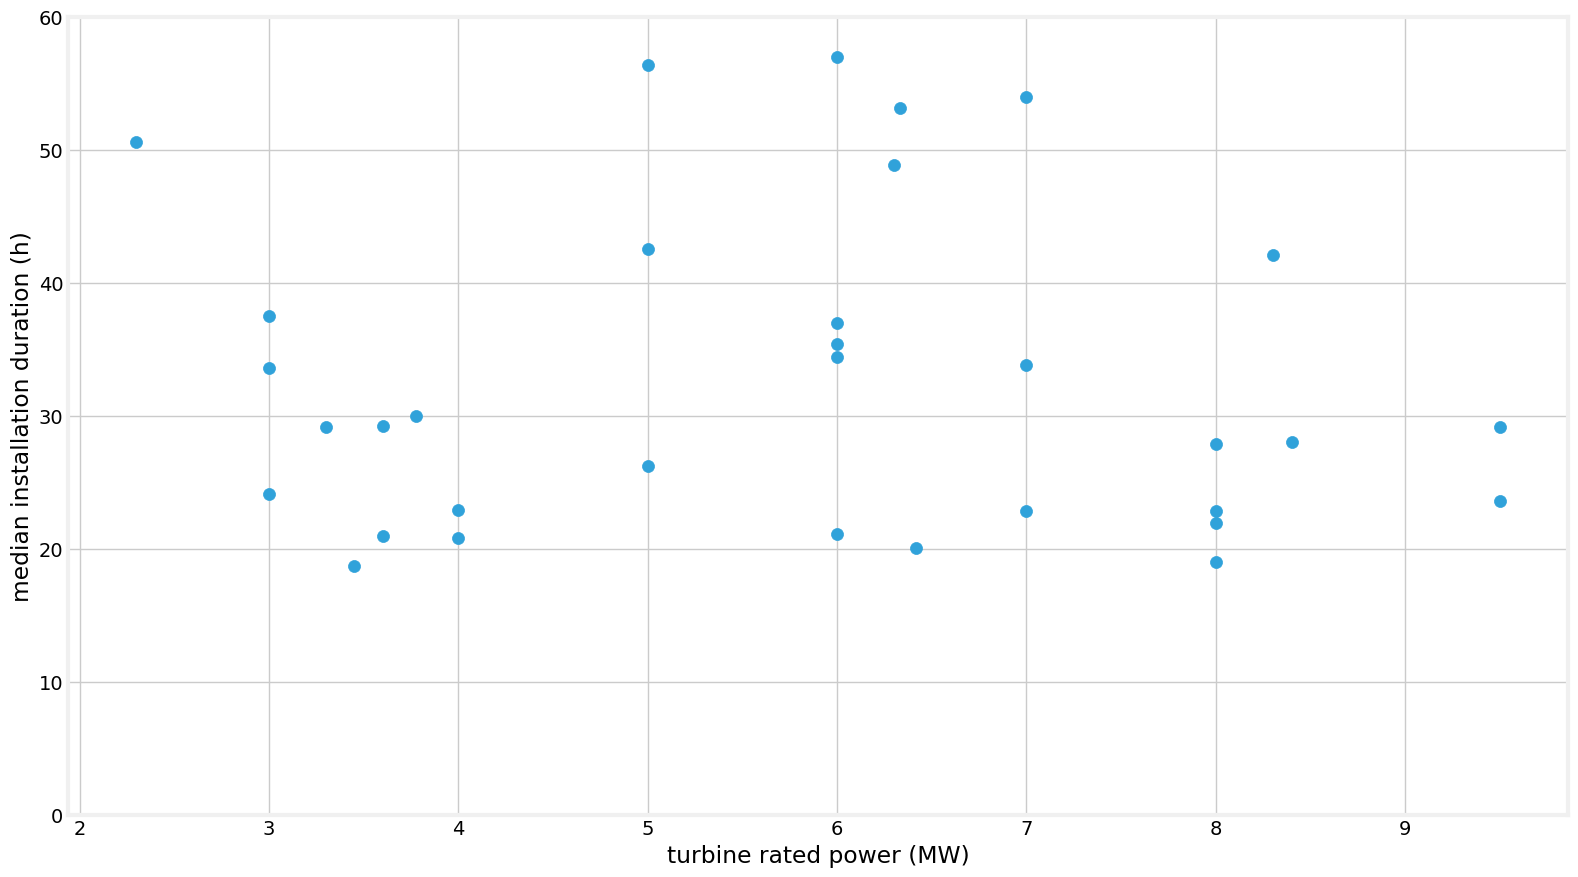

In [17]:
plt.figure(figsize=(16,9))
for i, installation in installations.items():
    power = windfarm_database.loc[i].turbine_power
    plt.scatter(power, installation.duration.median(), color='#30a2da', s=75)
plt.xlabel("turbine rated power (MW)")
plt.ylabel("median installation duration (h)")
plt.ylim([0, 60])
plt.tight_layout()
plt.savefig("../manuscript/figures/durations-rated-power.png", dpi=300)

In [20]:
all_weather = defaultdict(dict)

for location in all_installations.itertuples():
    possible_matches = glob.glob(os.path.join("../data/metocean/", f'*_{location.windfarm}_{location.location_key}_*.nc'))
    if possible_matches:
        all_weather[location.windfarm][location.location_key] = weather_df_from_era5(possible_matches[0])
        all_weather[location.windfarm][location.location_key].insert(loc=17, column='abs_wind_100', value = np.sqrt(np.power(all_weather[location.windfarm][location.location_key].u100, 2) + np.power(all_weather[location.windfarm][location.location_key].v100, 2)))

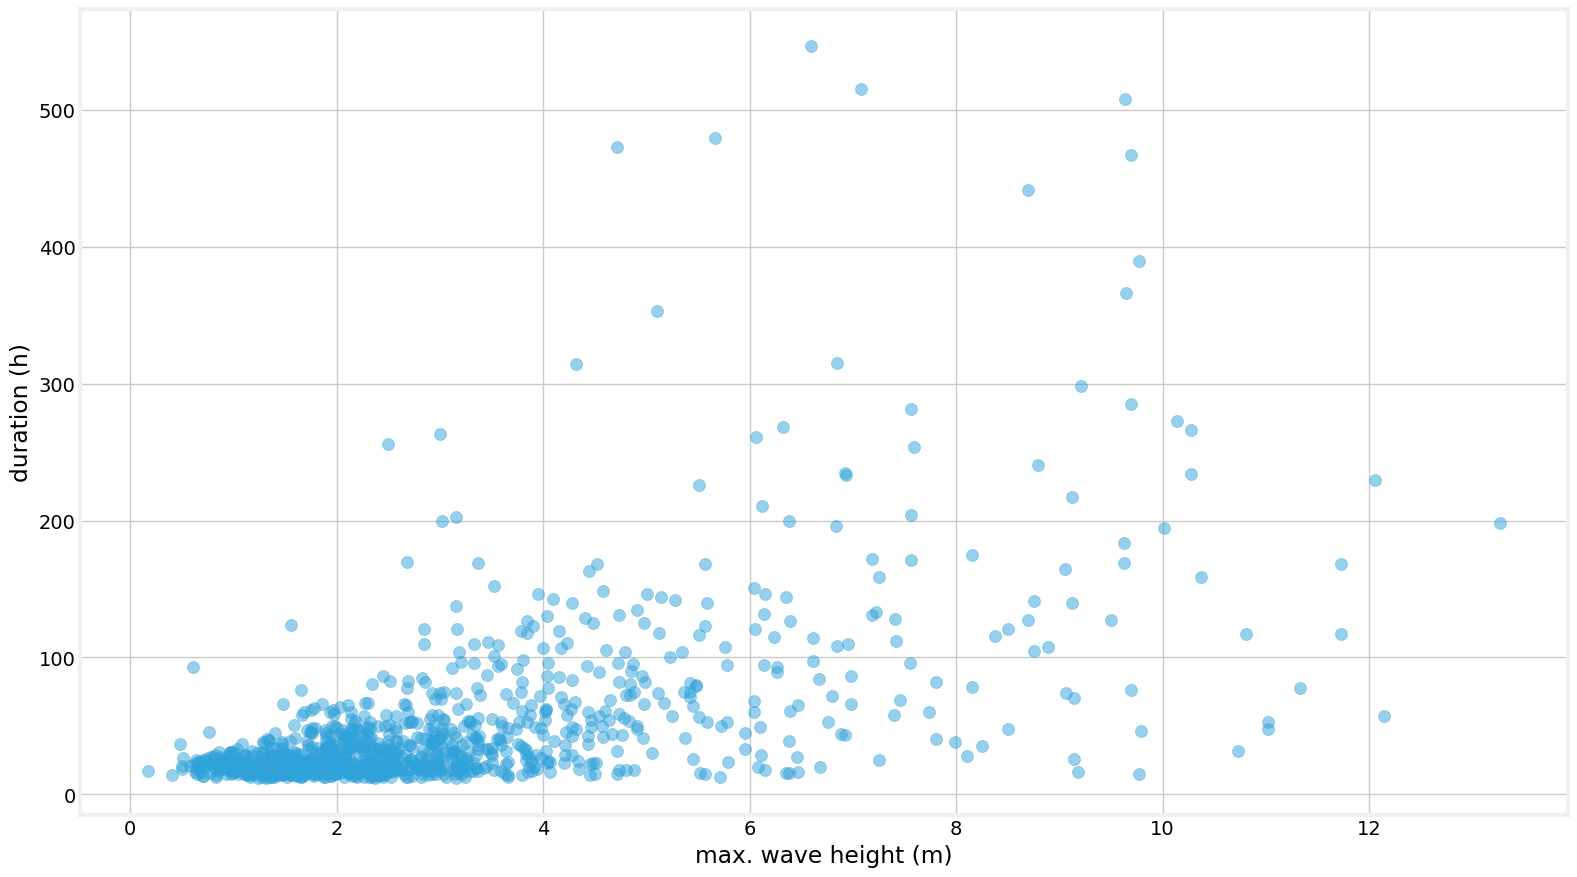

In [21]:
plt.figure(figsize=(16,9))
for location in all_installations.itertuples():
    if location.windfarm in all_weather:
        if location.location_key in all_weather[location.windfarm]:
            plt.scatter(all_weather[location.windfarm][location.location_key].hmax.max(), location.duration, color='#30a2da', s=75, alpha=0.5)

plt.xlabel('max. wave height (m)')
plt.ylabel('duration (h)')
plt.tight_layout()
plt.savefig("../manuscript/figures/duration-max-wave-height.png", dpi=300)

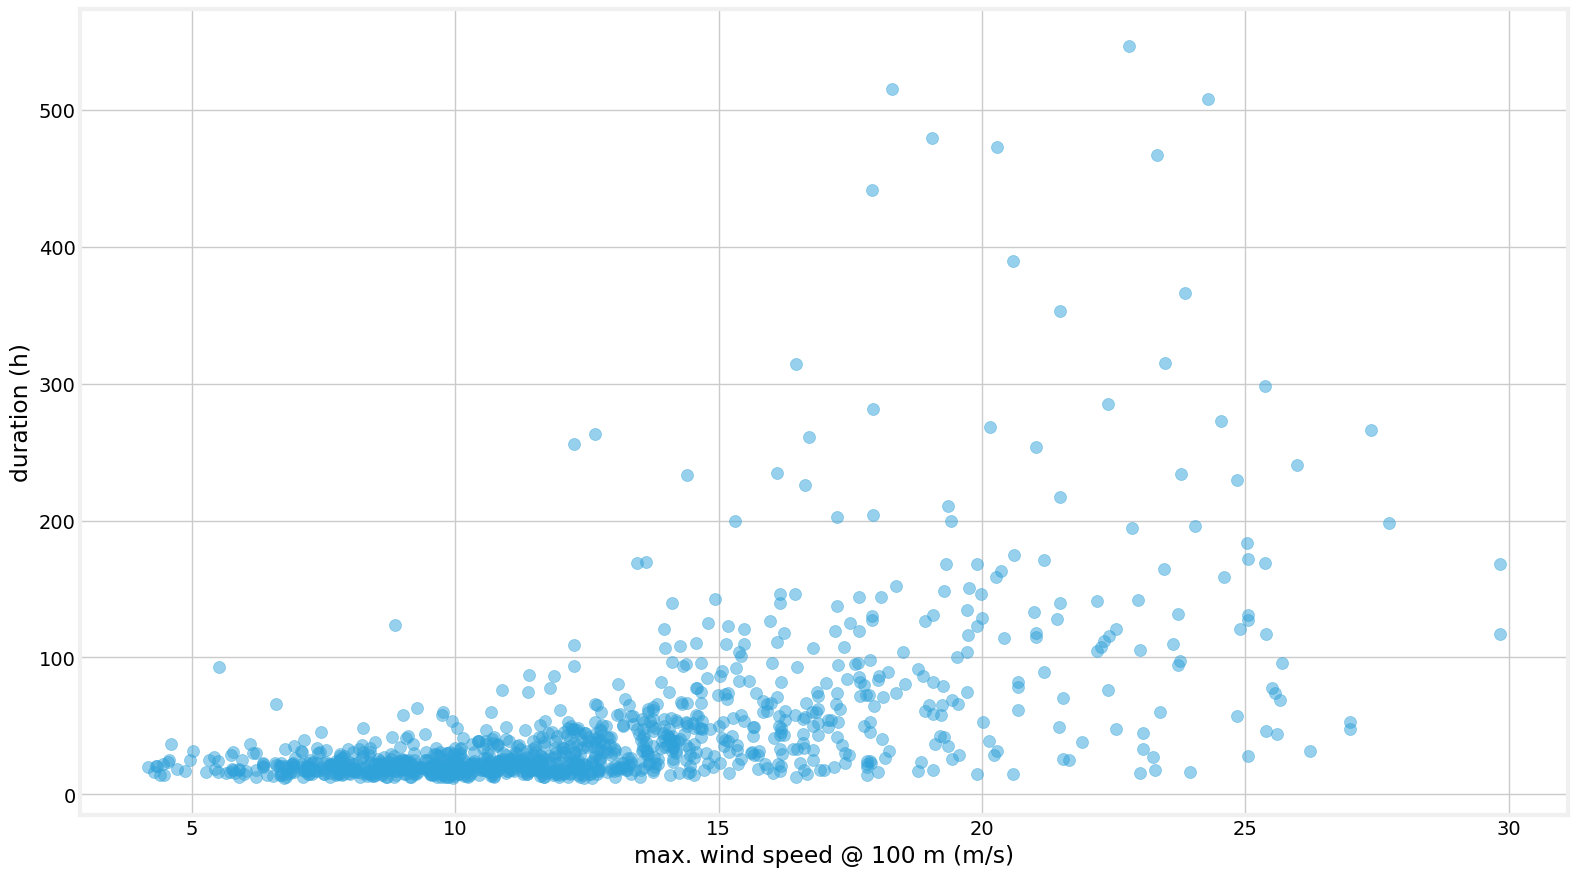

In [22]:
plt.figure(figsize=(16,9))
for location in all_installations.itertuples():
    if location.windfarm in all_weather:
        if location.location_key in all_weather[location.windfarm]:
            plt.scatter(all_weather[location.windfarm][location.location_key].abs_wind_100.max(), location.duration, color='#30a2da', s=75, alpha=0.5)
plt.xlabel('max. wind speed @ 100 m (m/s)')
plt.ylabel('duration (h)')
plt.tight_layout()
plt.savefig("../manuscript/figures/duration-max-wind-speed.png", dpi=300)

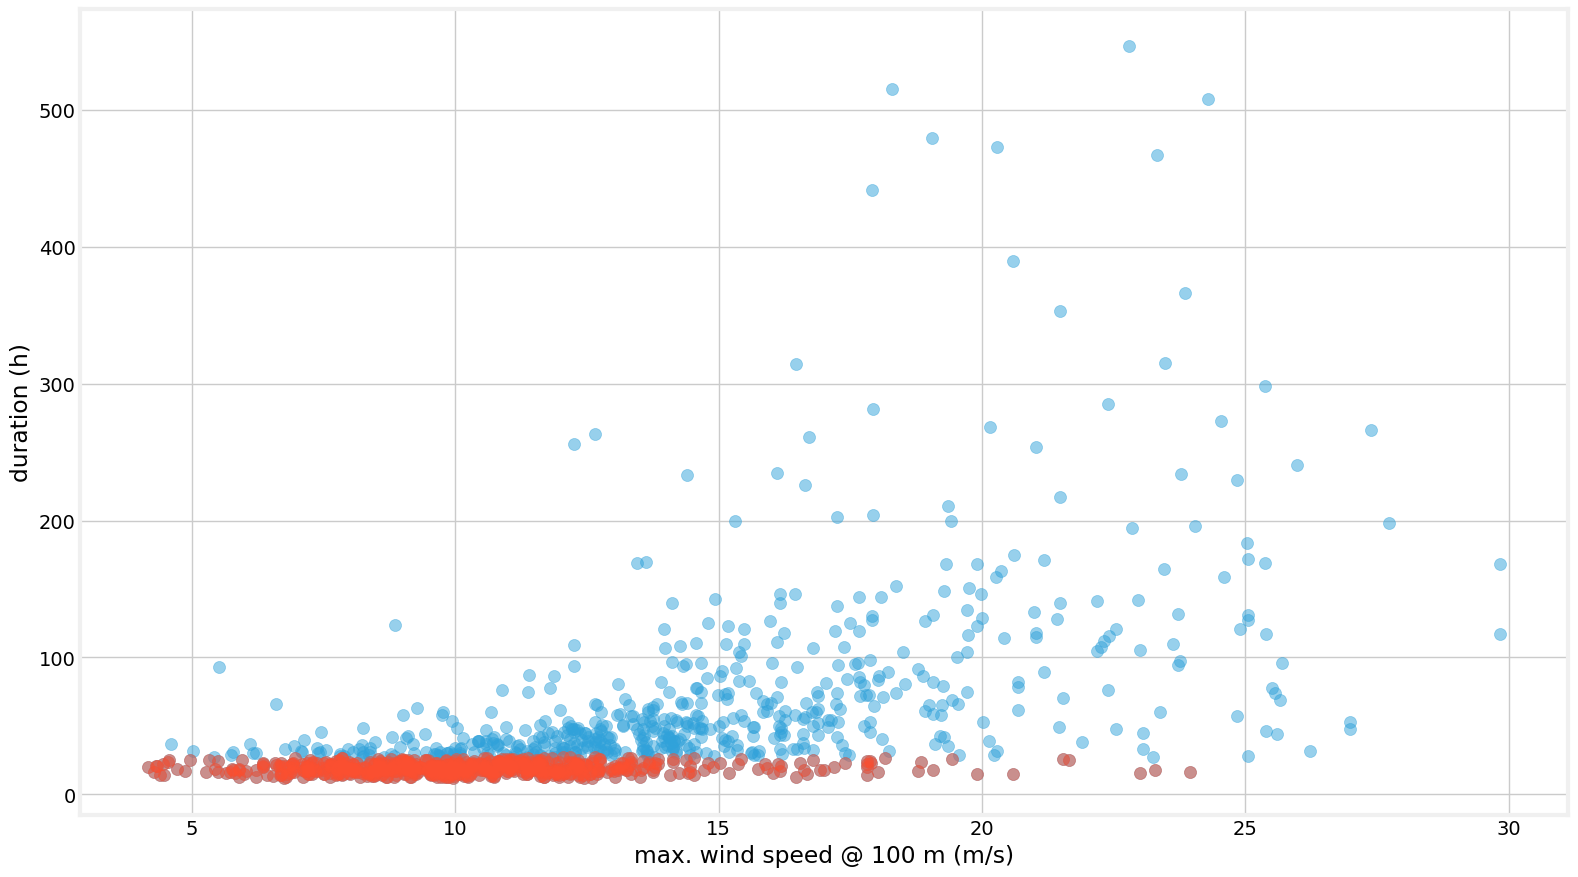

In [24]:
plt.figure(figsize=(16,9))
for location in all_installations.itertuples():
    if location.windfarm in all_weather:
        if location.location_key in all_weather[location.windfarm]:
            plt.scatter(all_weather[location.windfarm][location.location_key].abs_wind_100.max(), location.duration, color='#30a2da', s=75, alpha=0.5)
for location in all_installations[all_installations.duration < 27].itertuples():
    if location.windfarm in all_weather:
        if location.location_key in all_weather[location.windfarm]:
            plt.scatter(all_weather[location.windfarm][location.location_key].abs_wind_100.max(), location.duration, color='#fc4f30', s=75, alpha=0.5)
plt.xlabel('max. wind speed @ 100 m (m/s)')
plt.ylabel('duration (h)')
plt.tight_layout()

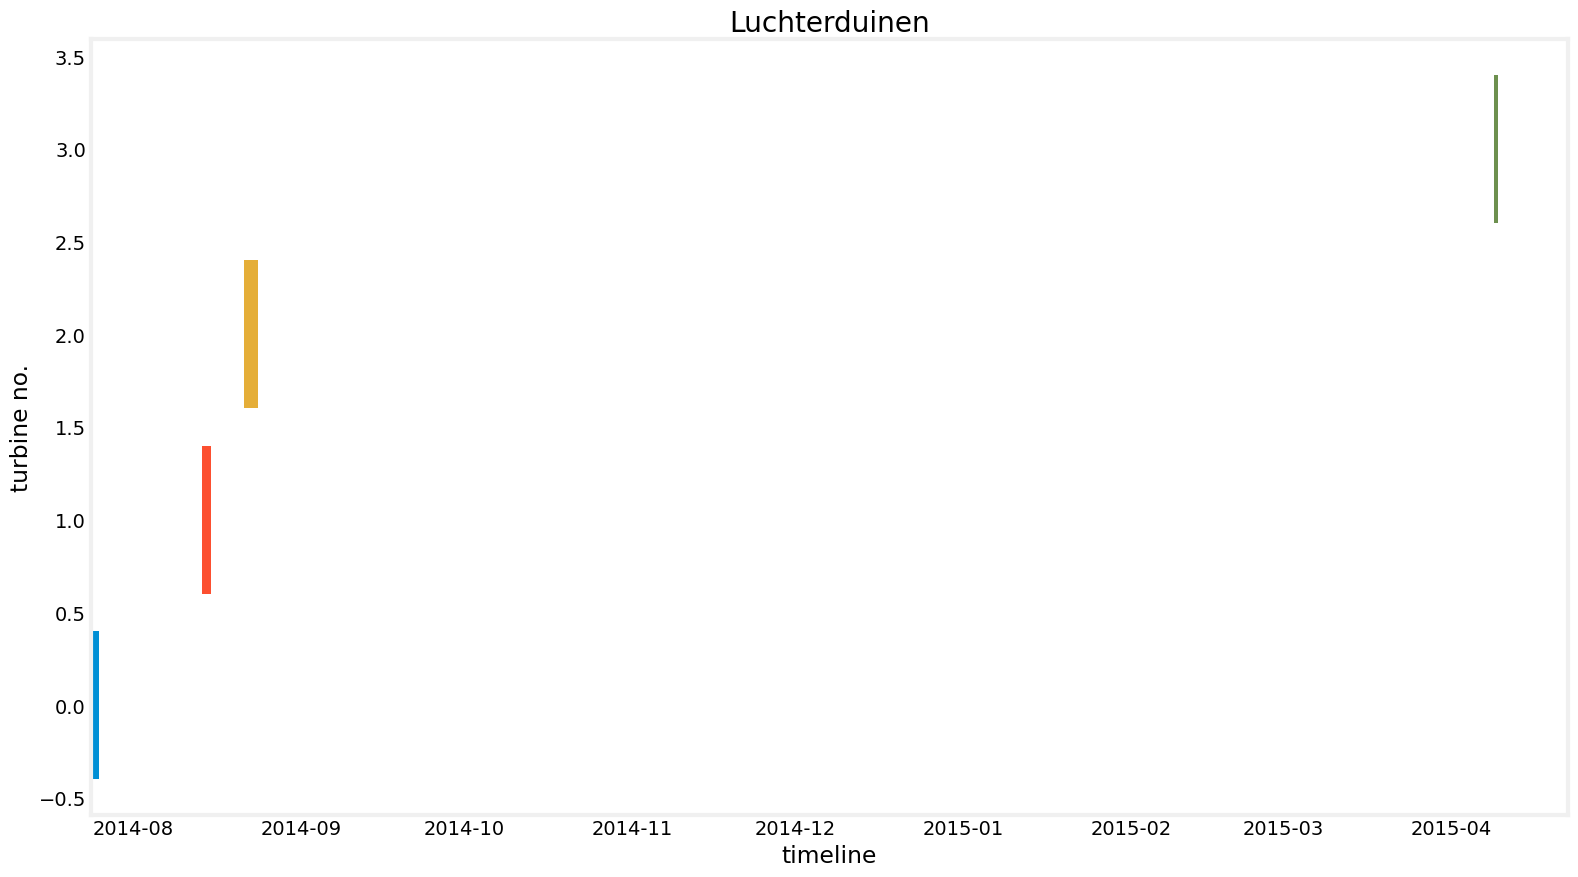

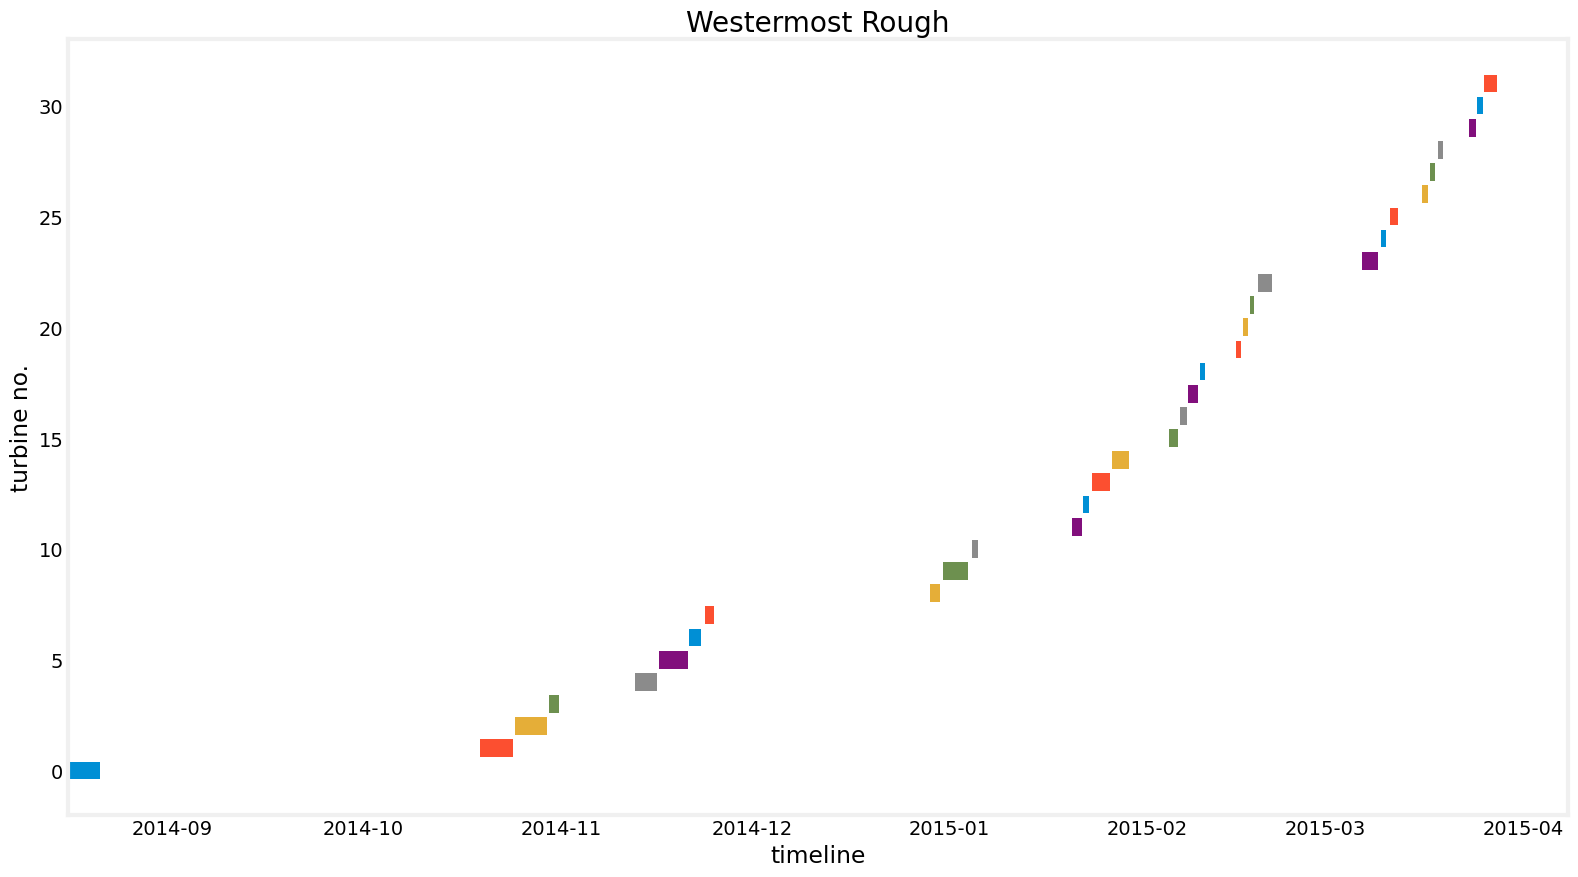

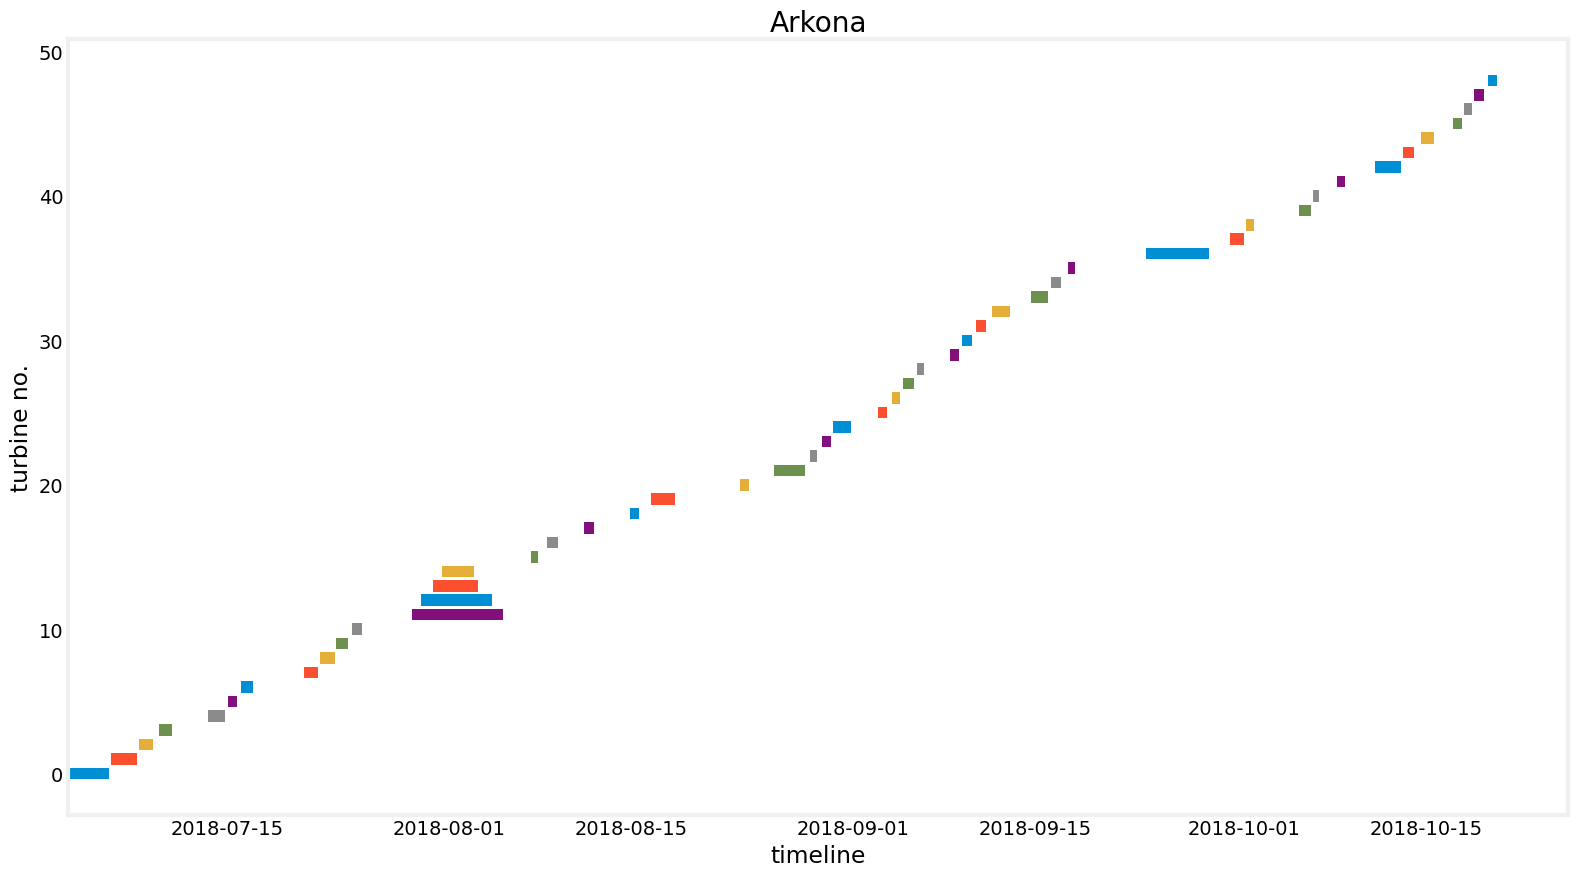

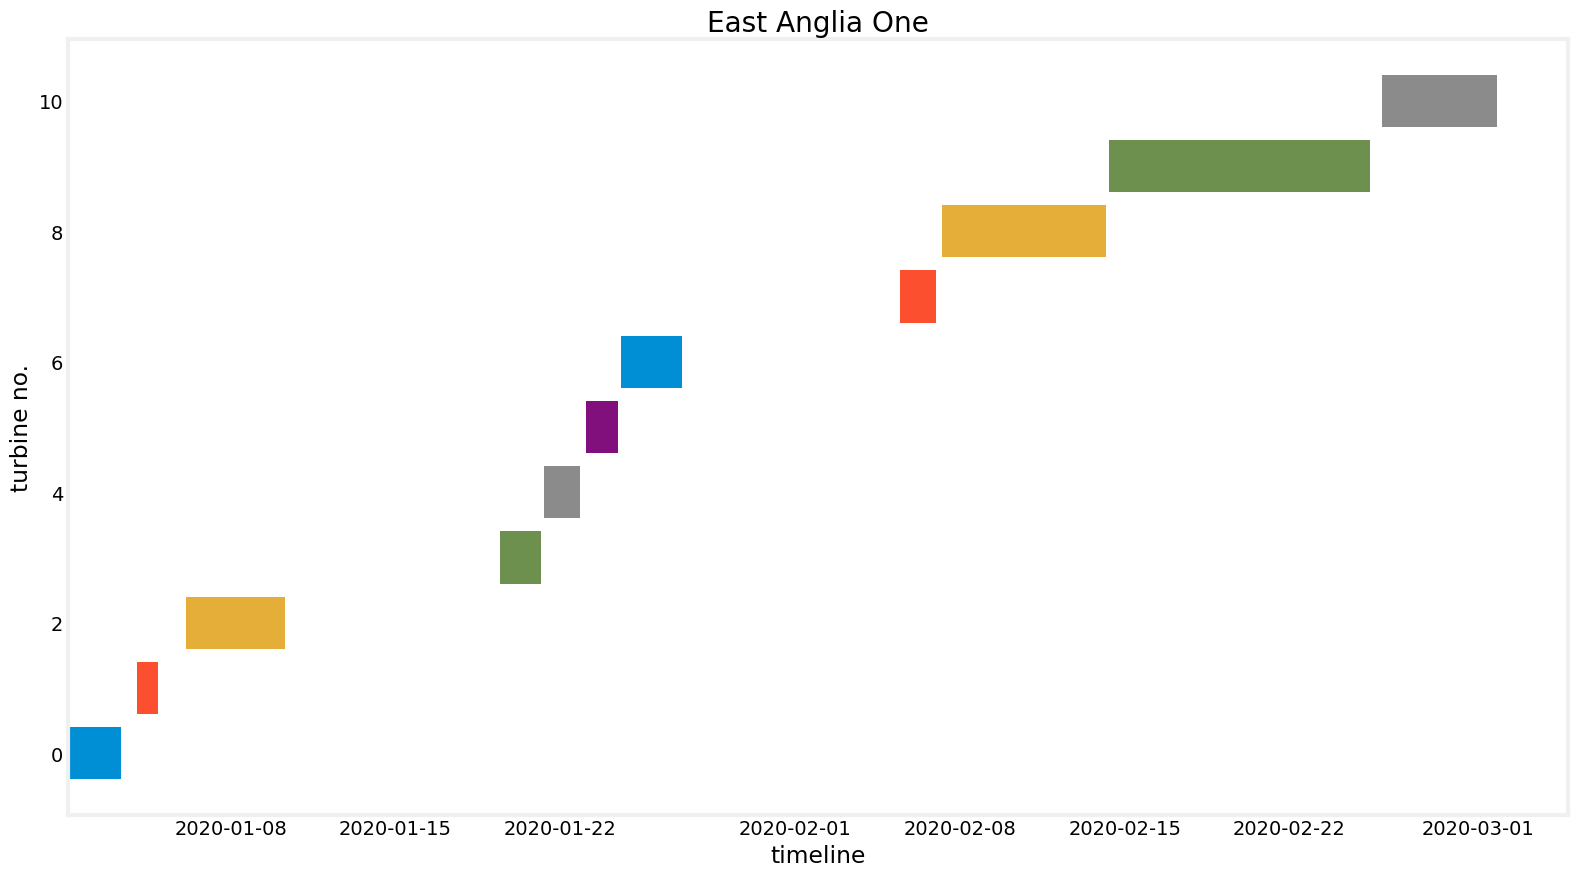

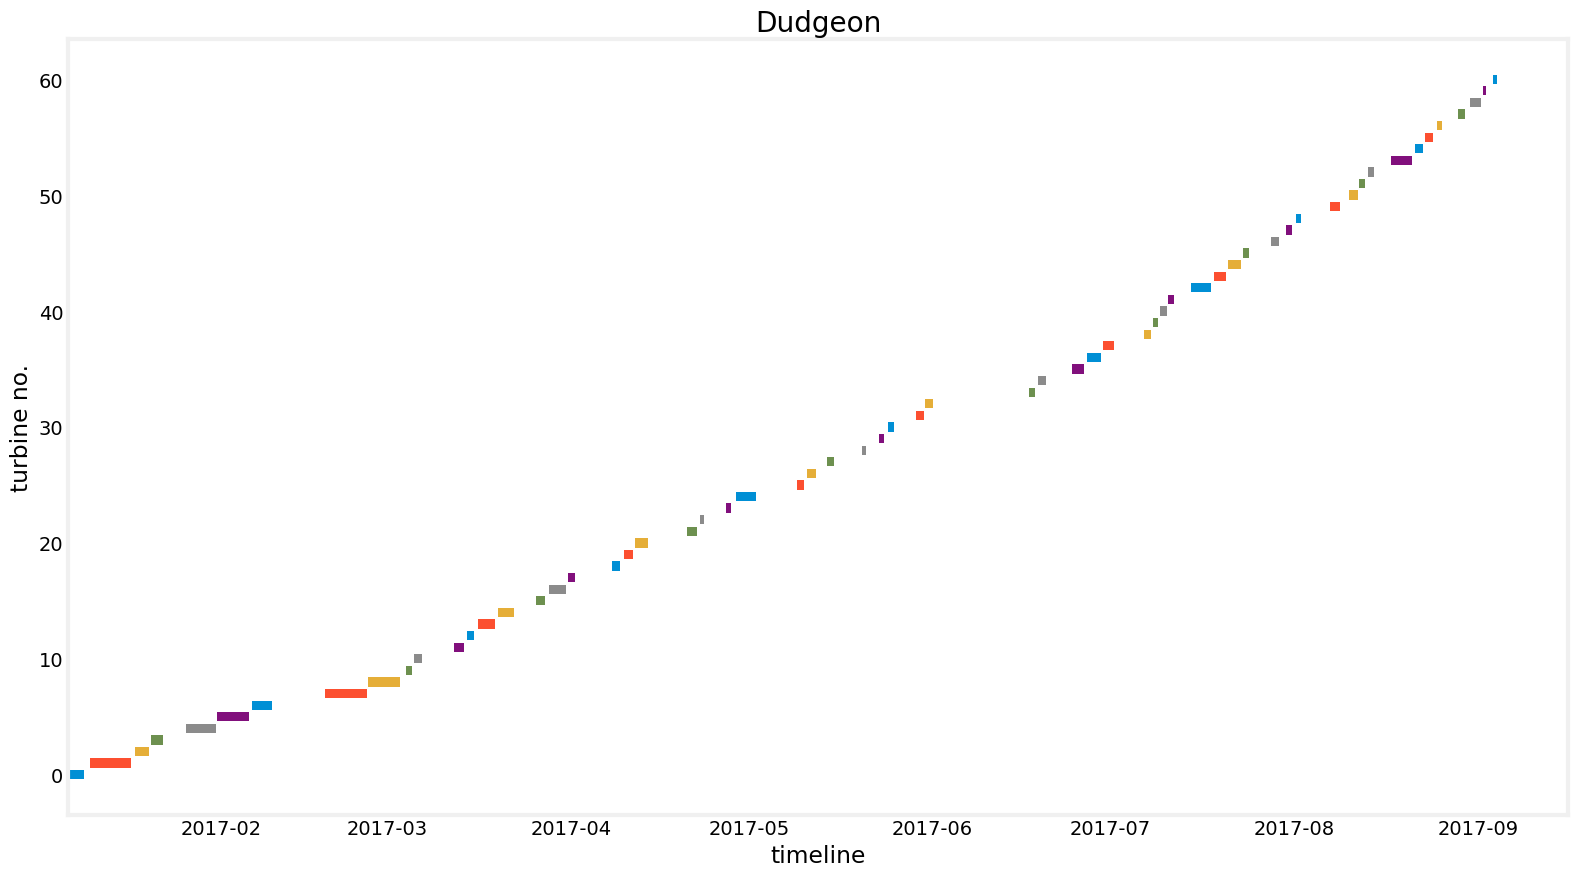

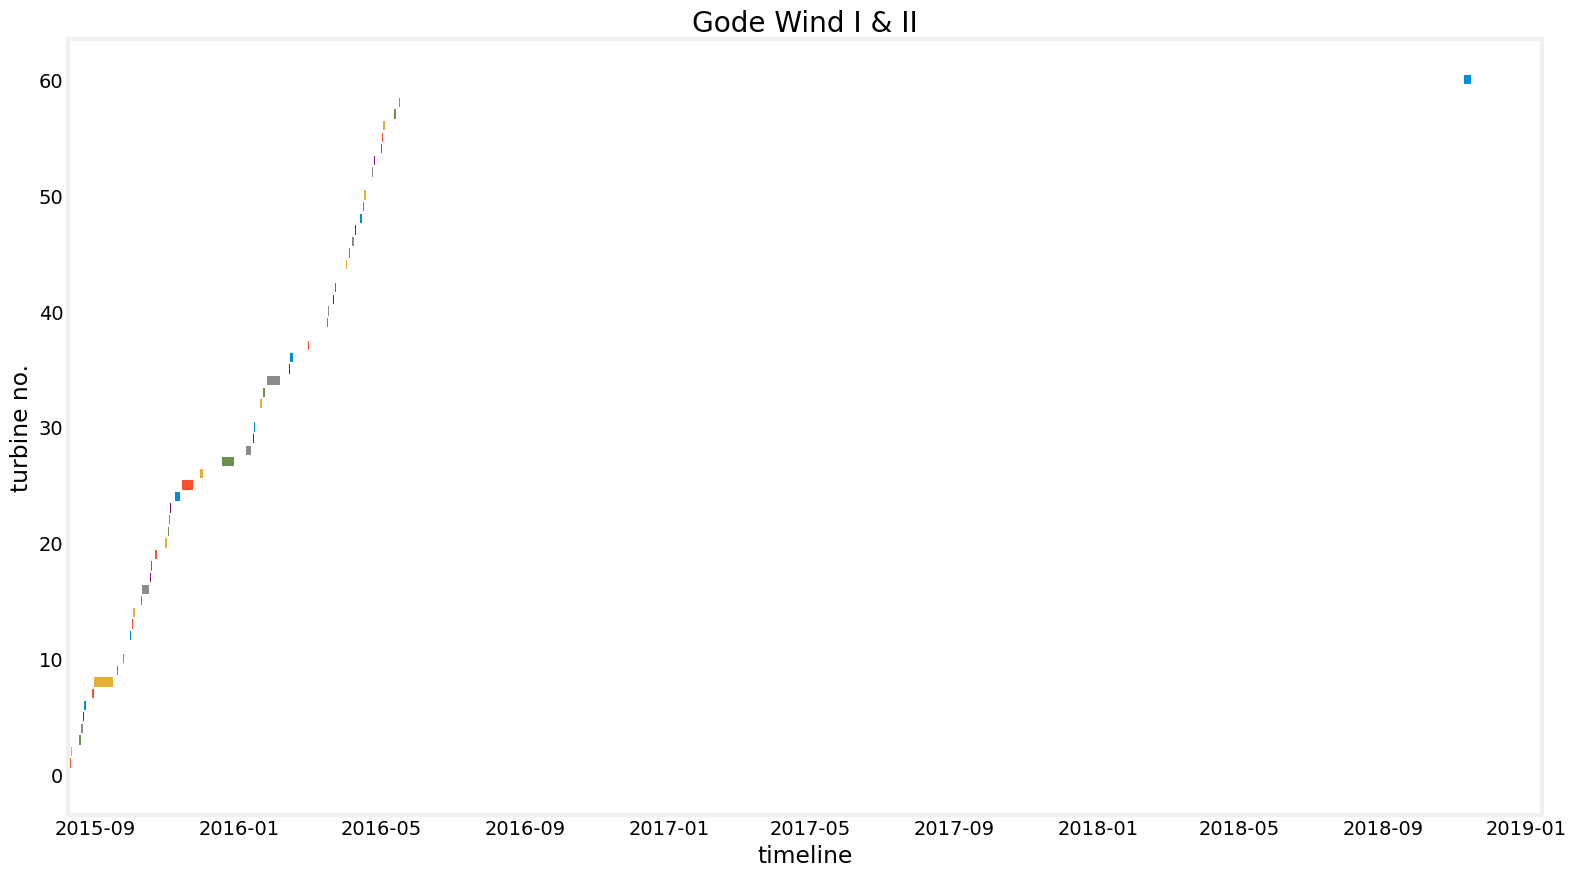

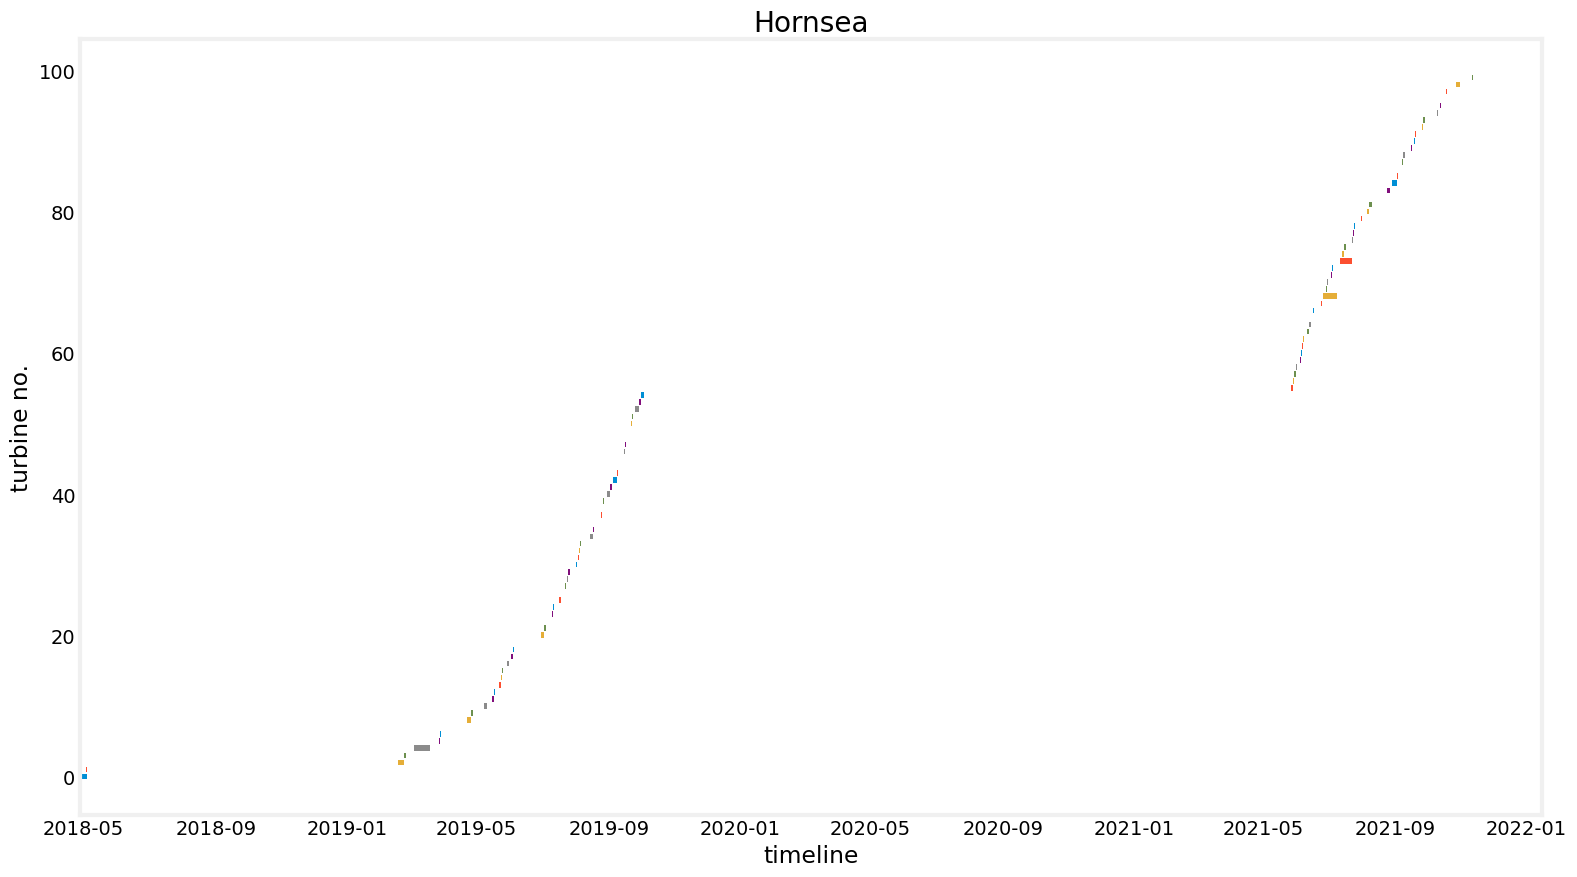

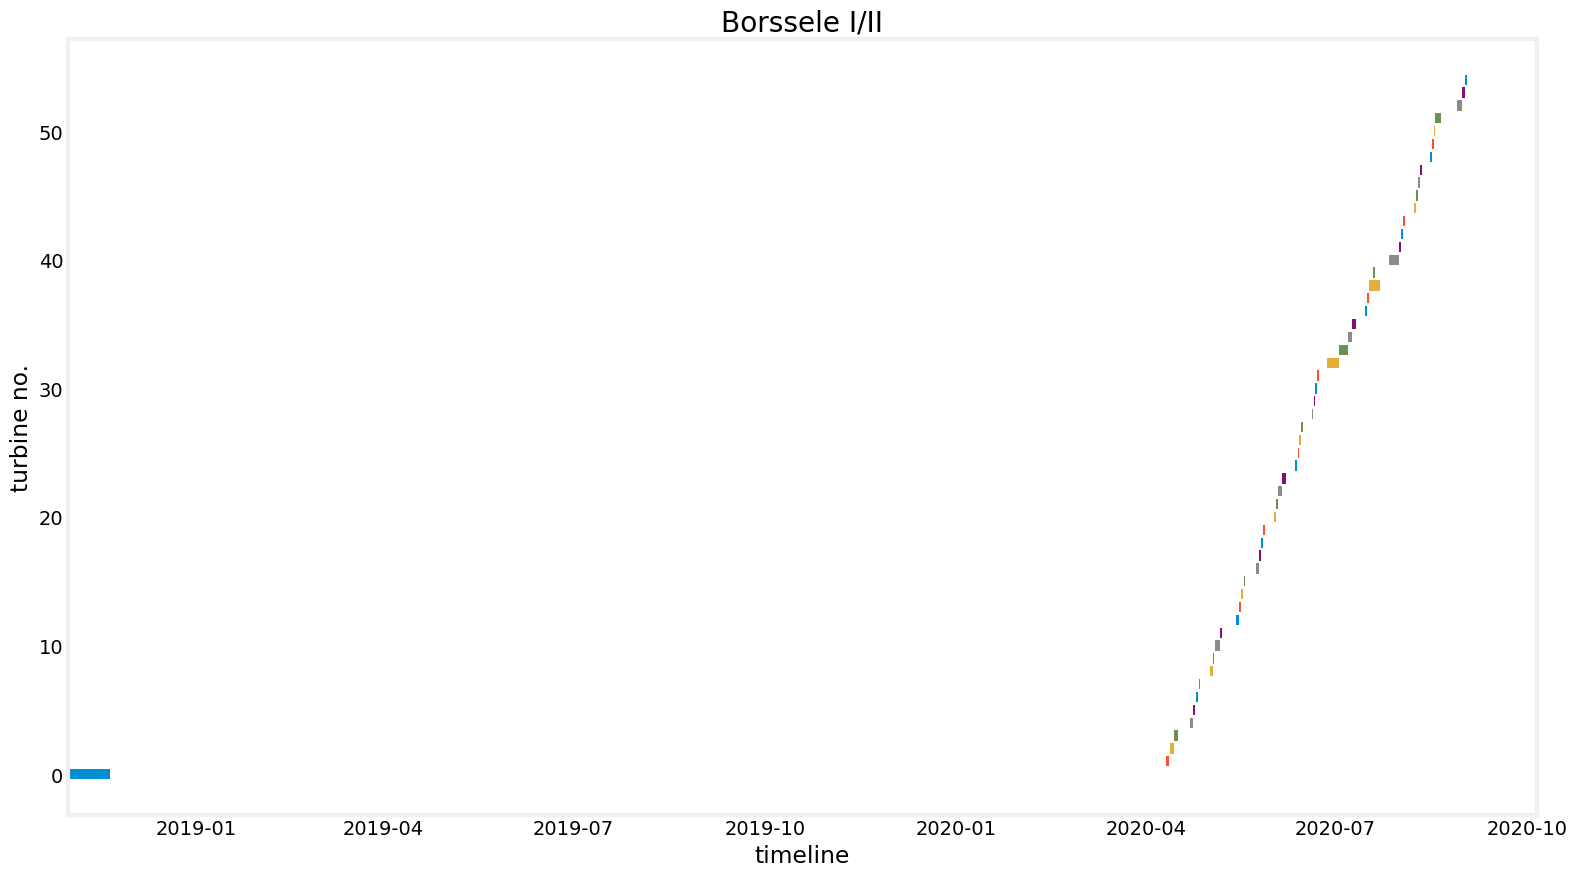

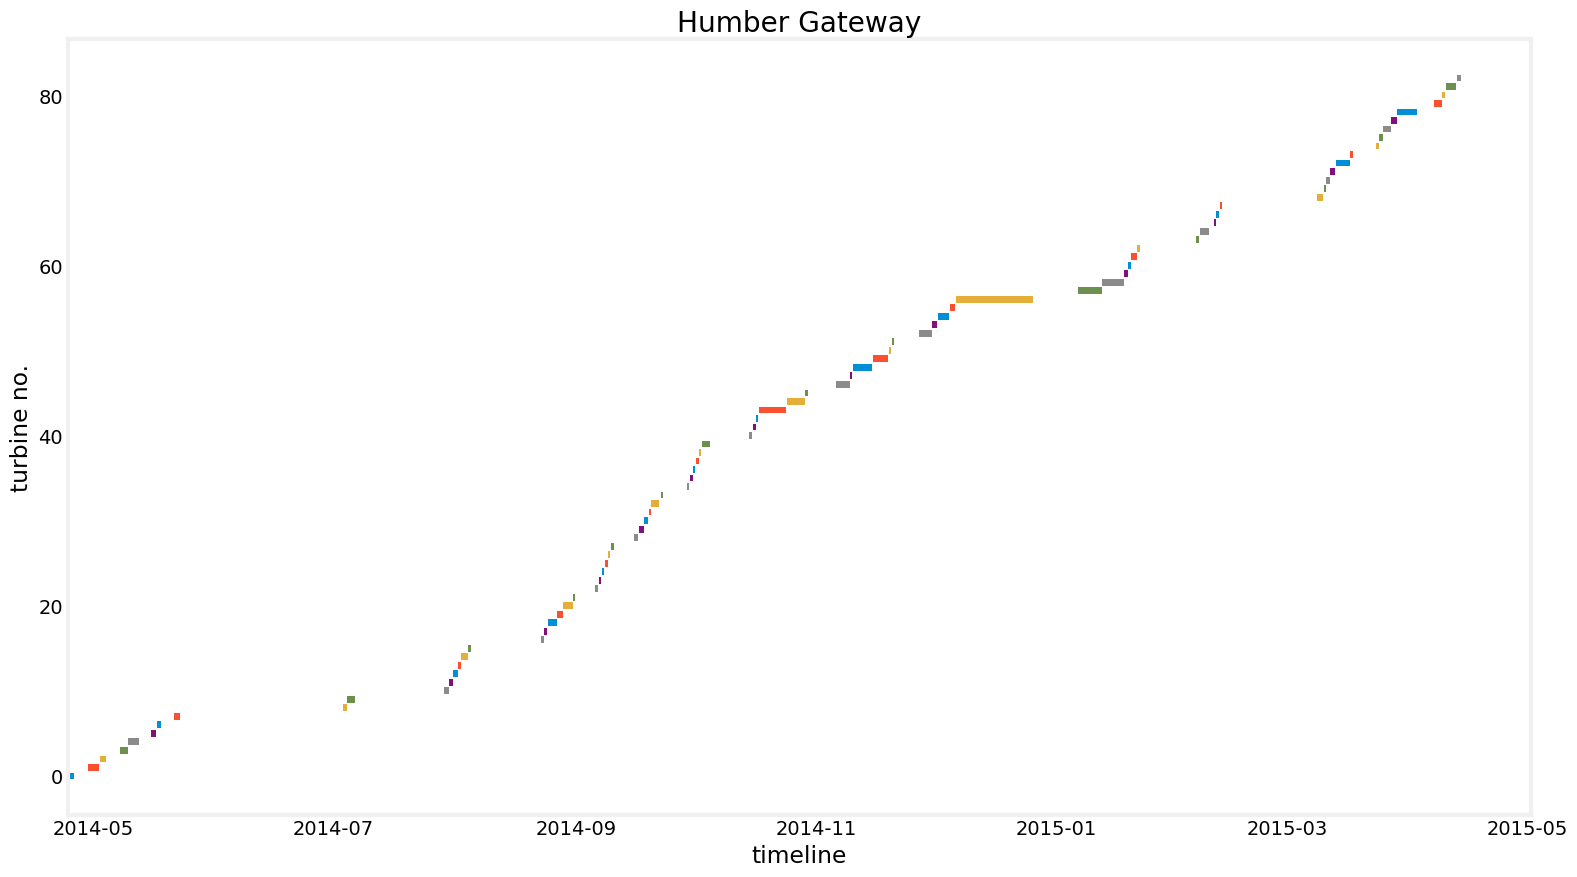

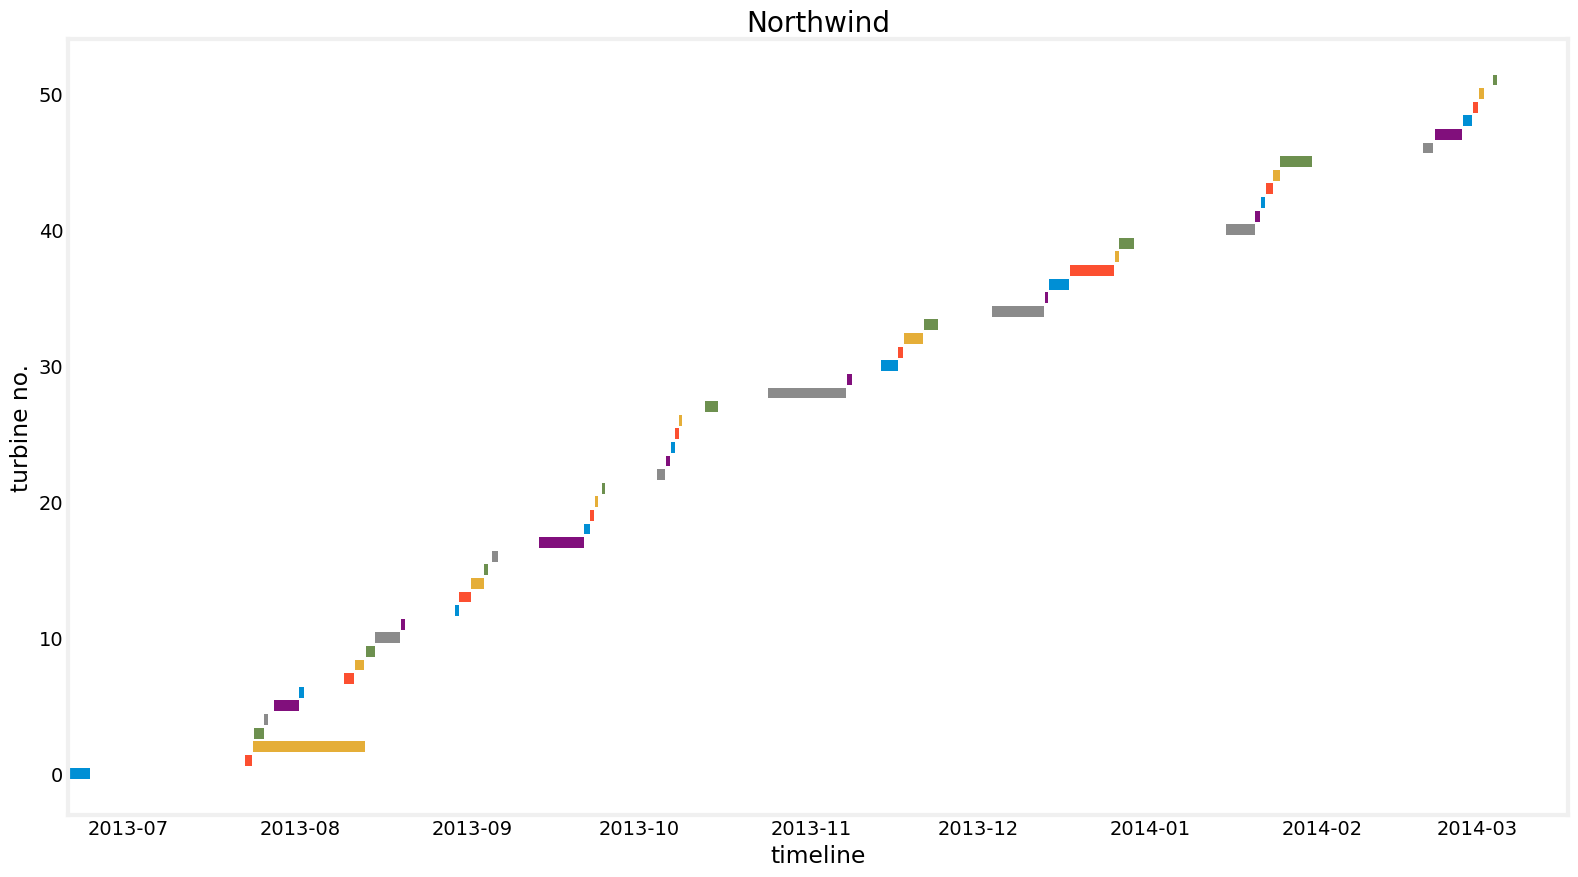

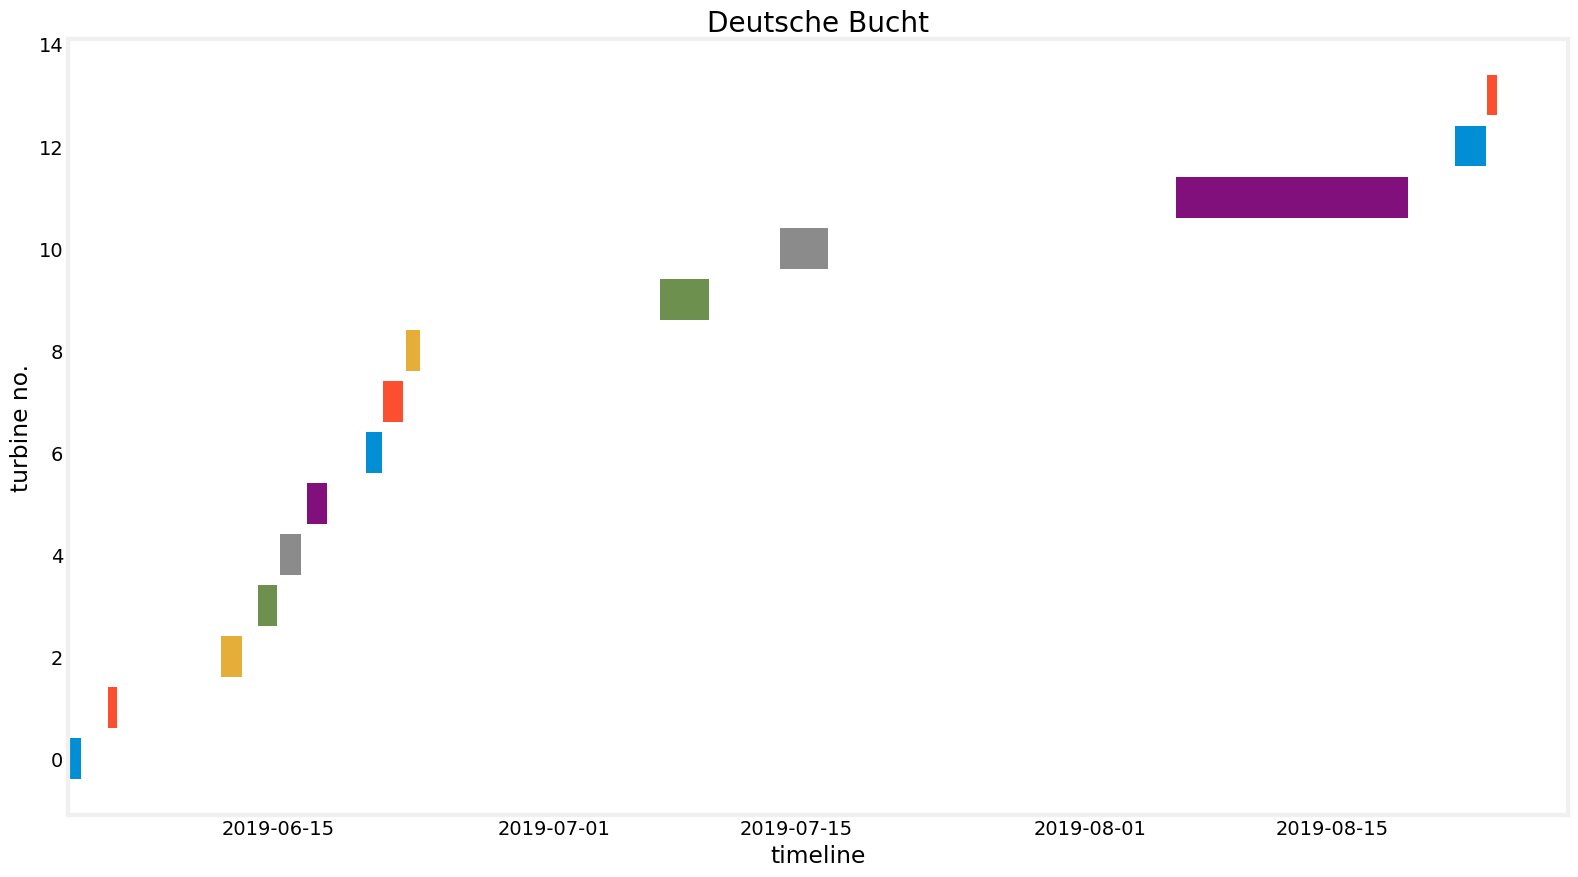

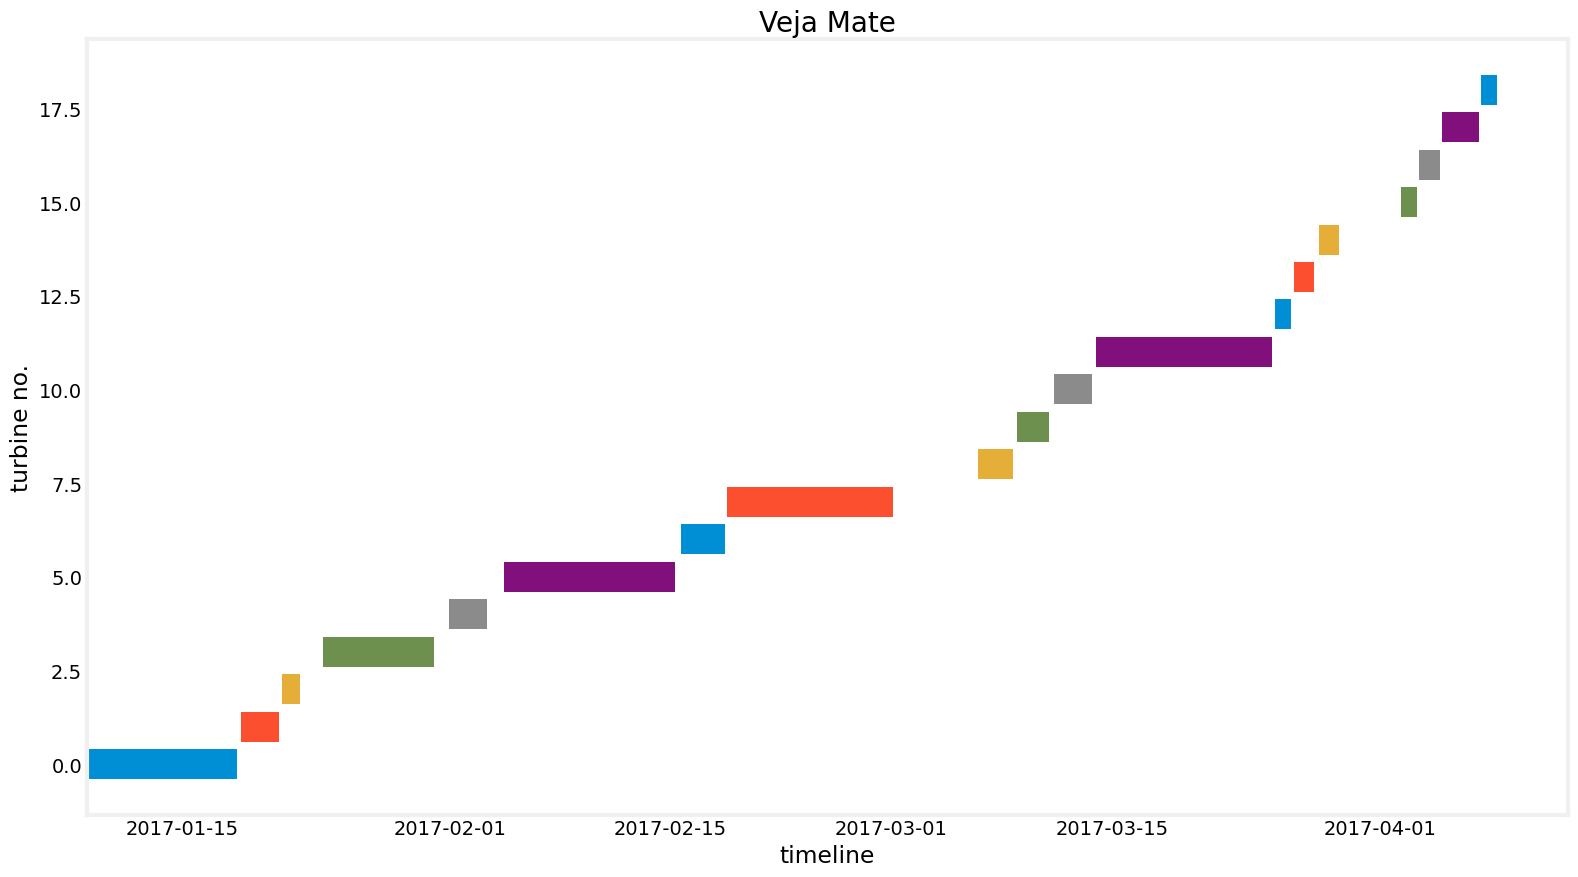

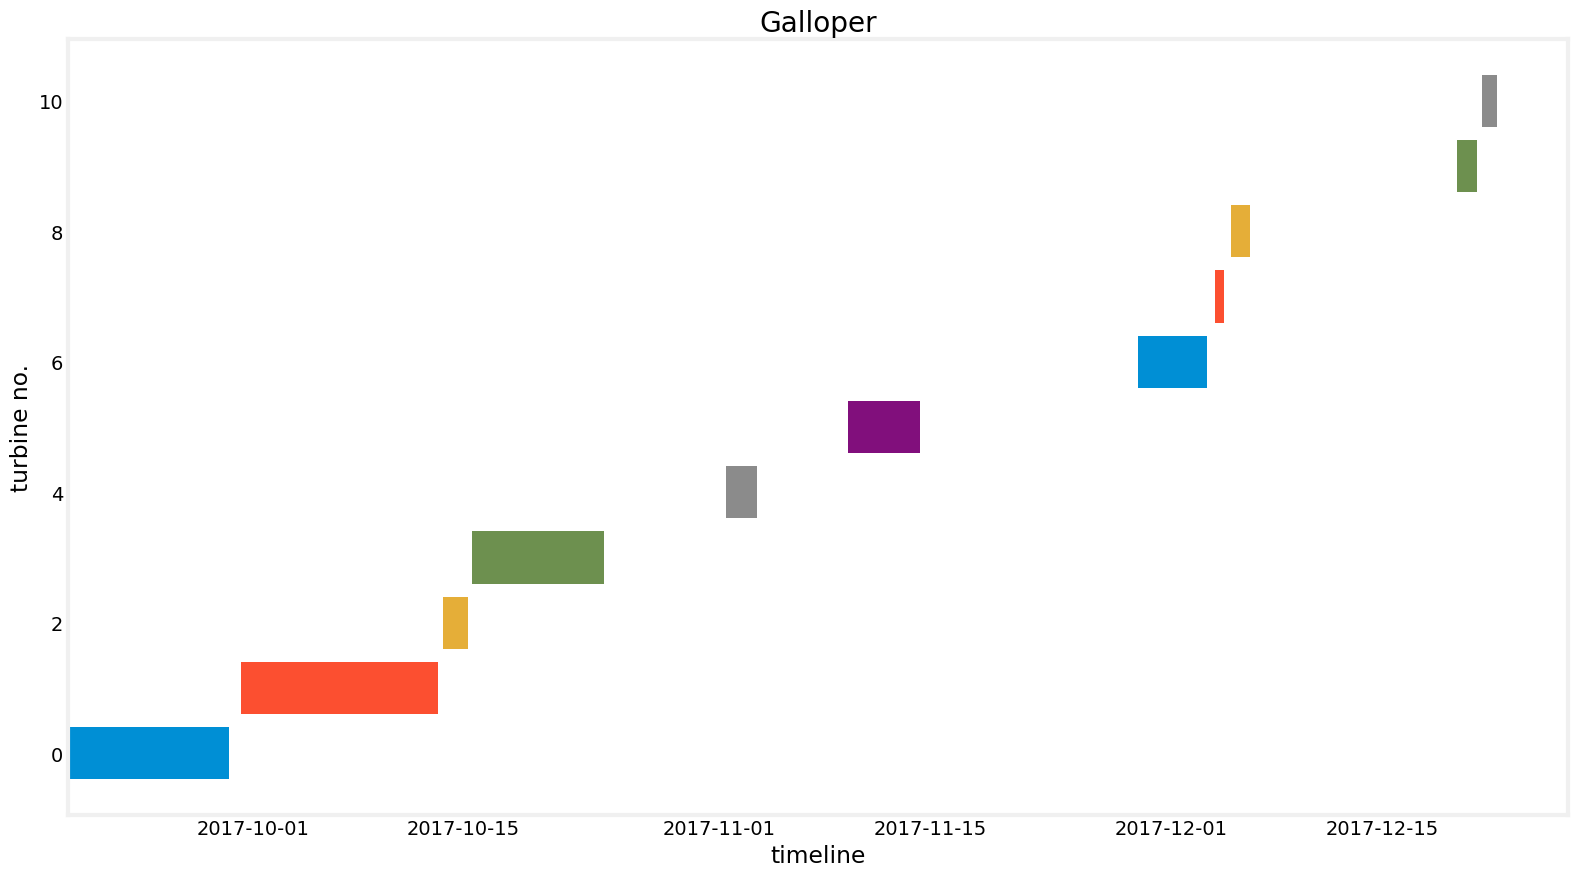

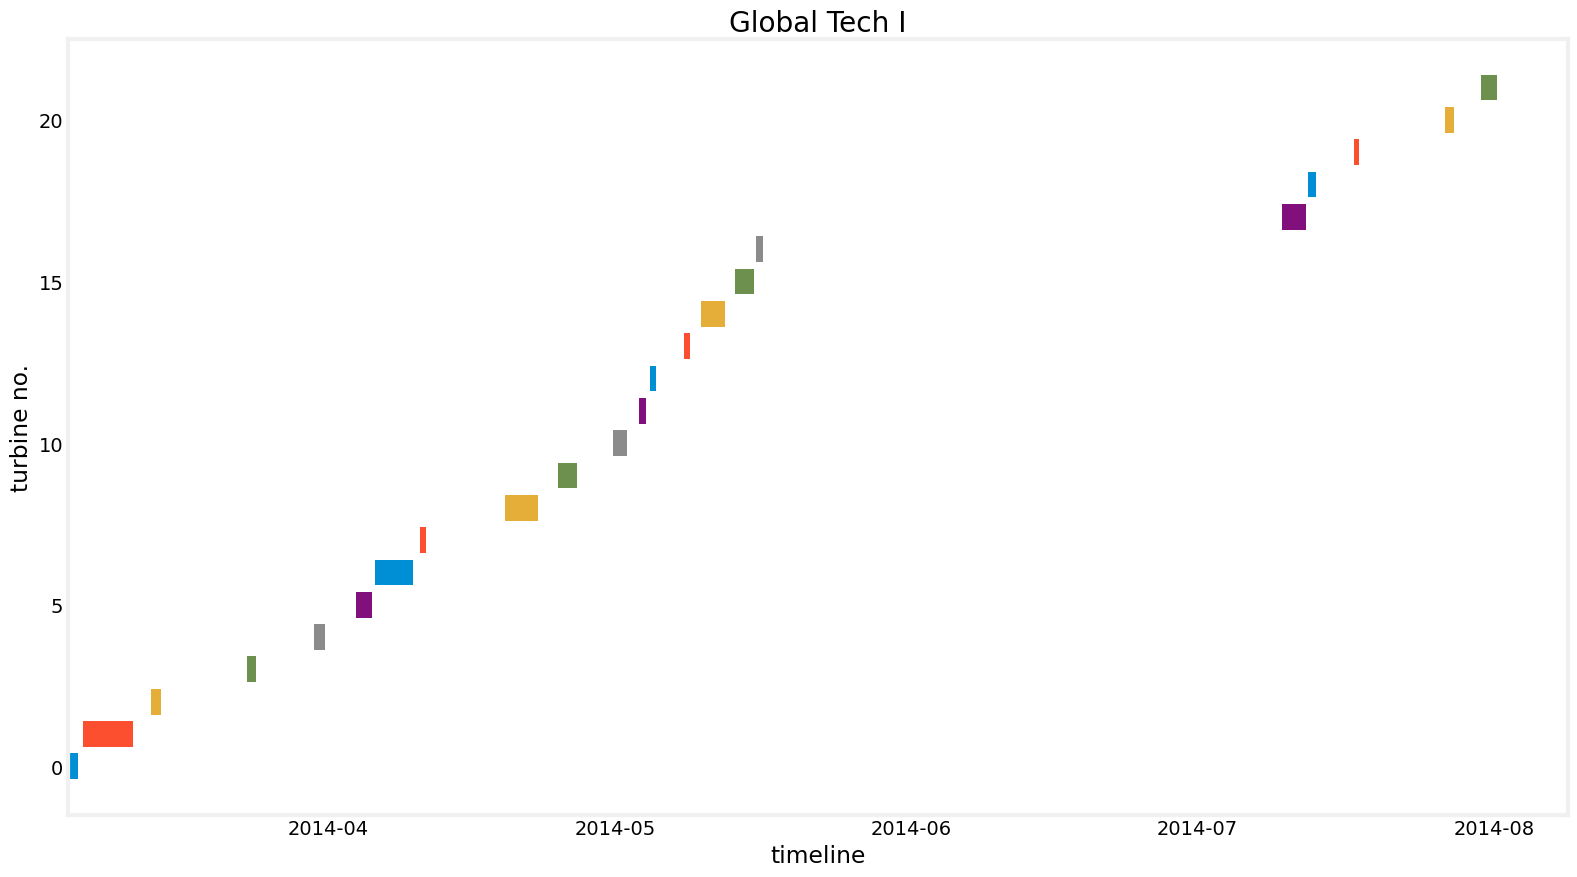

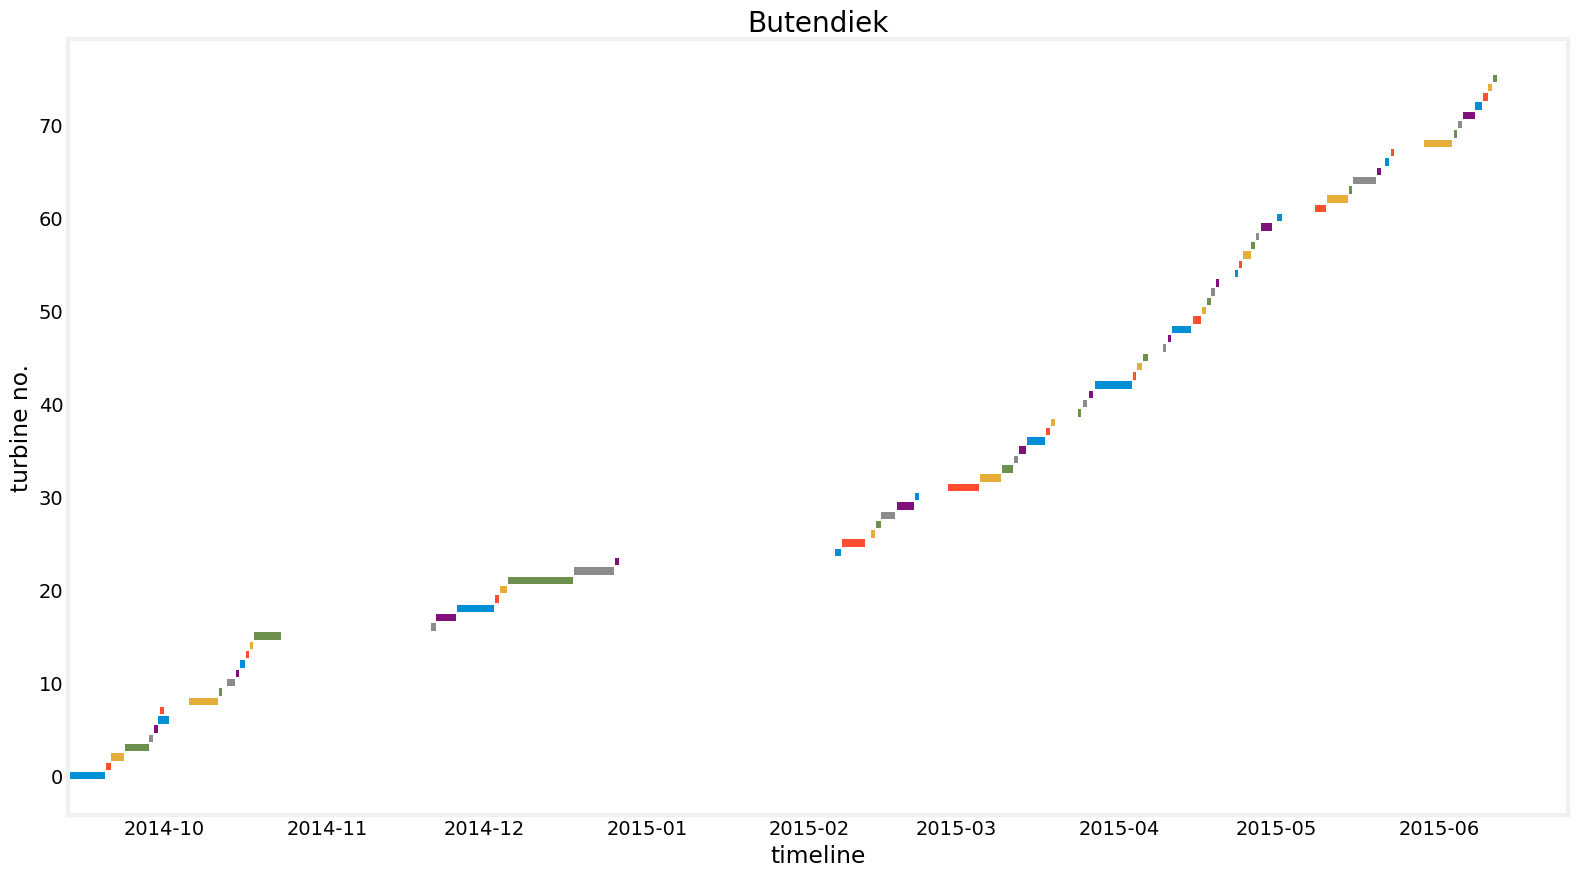

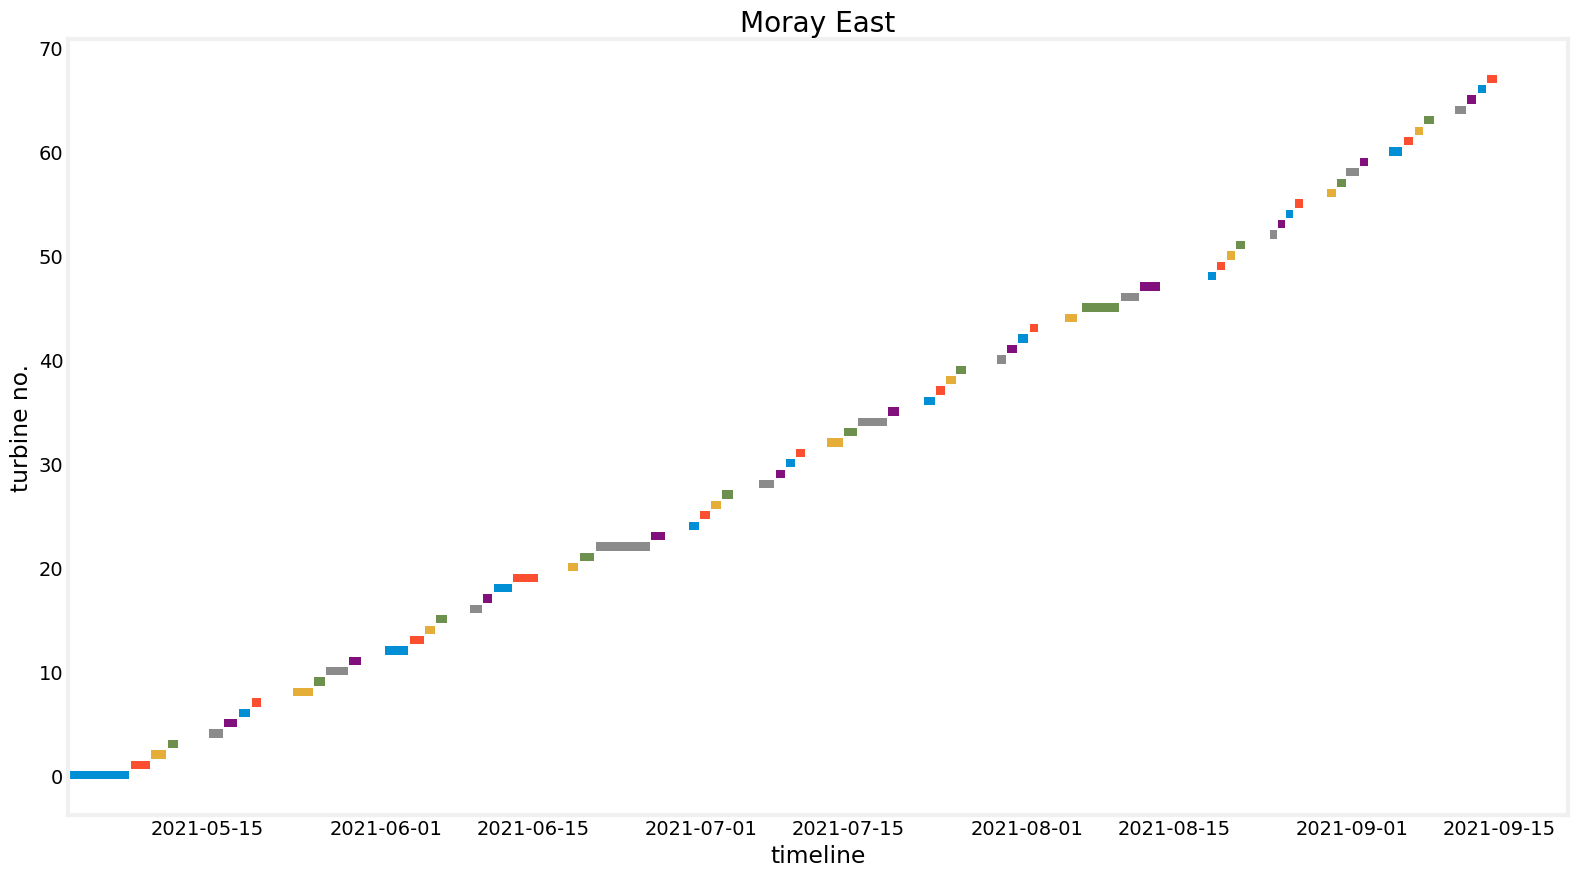

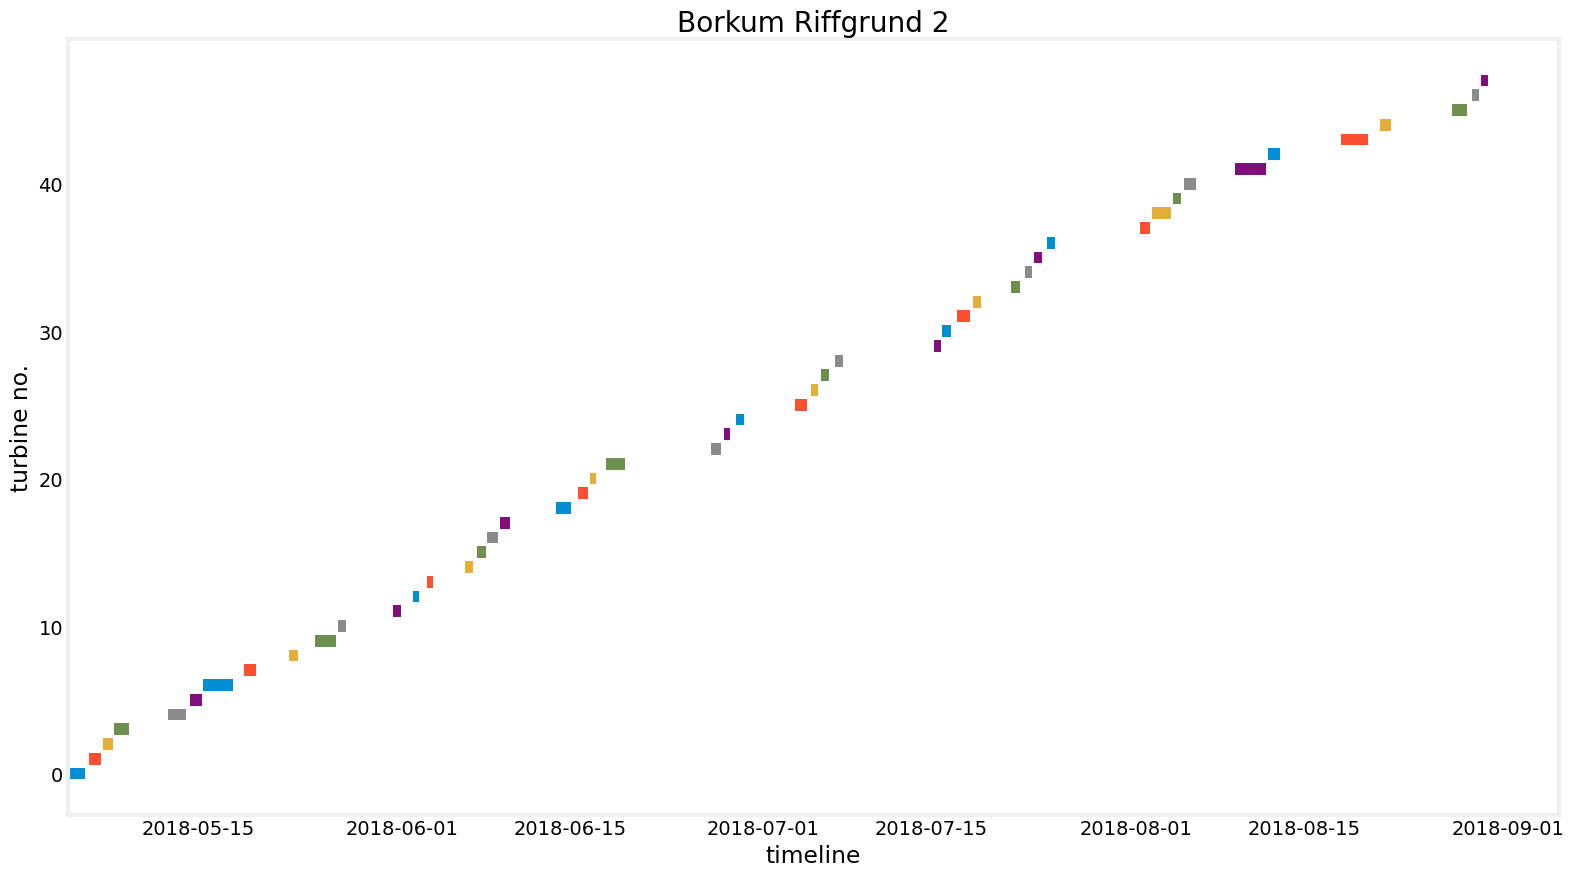

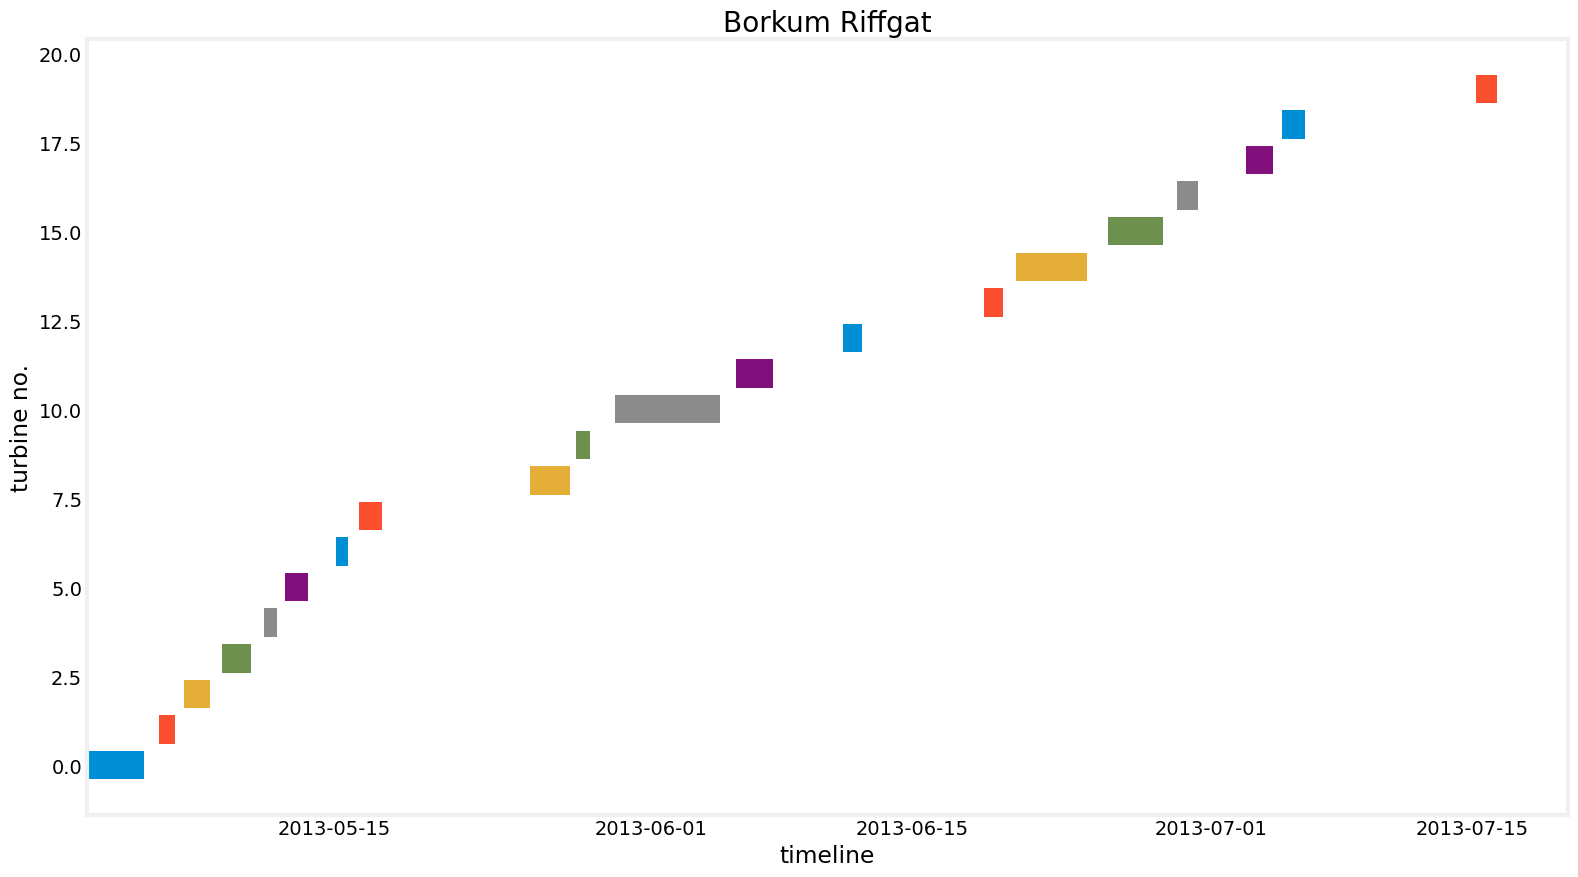

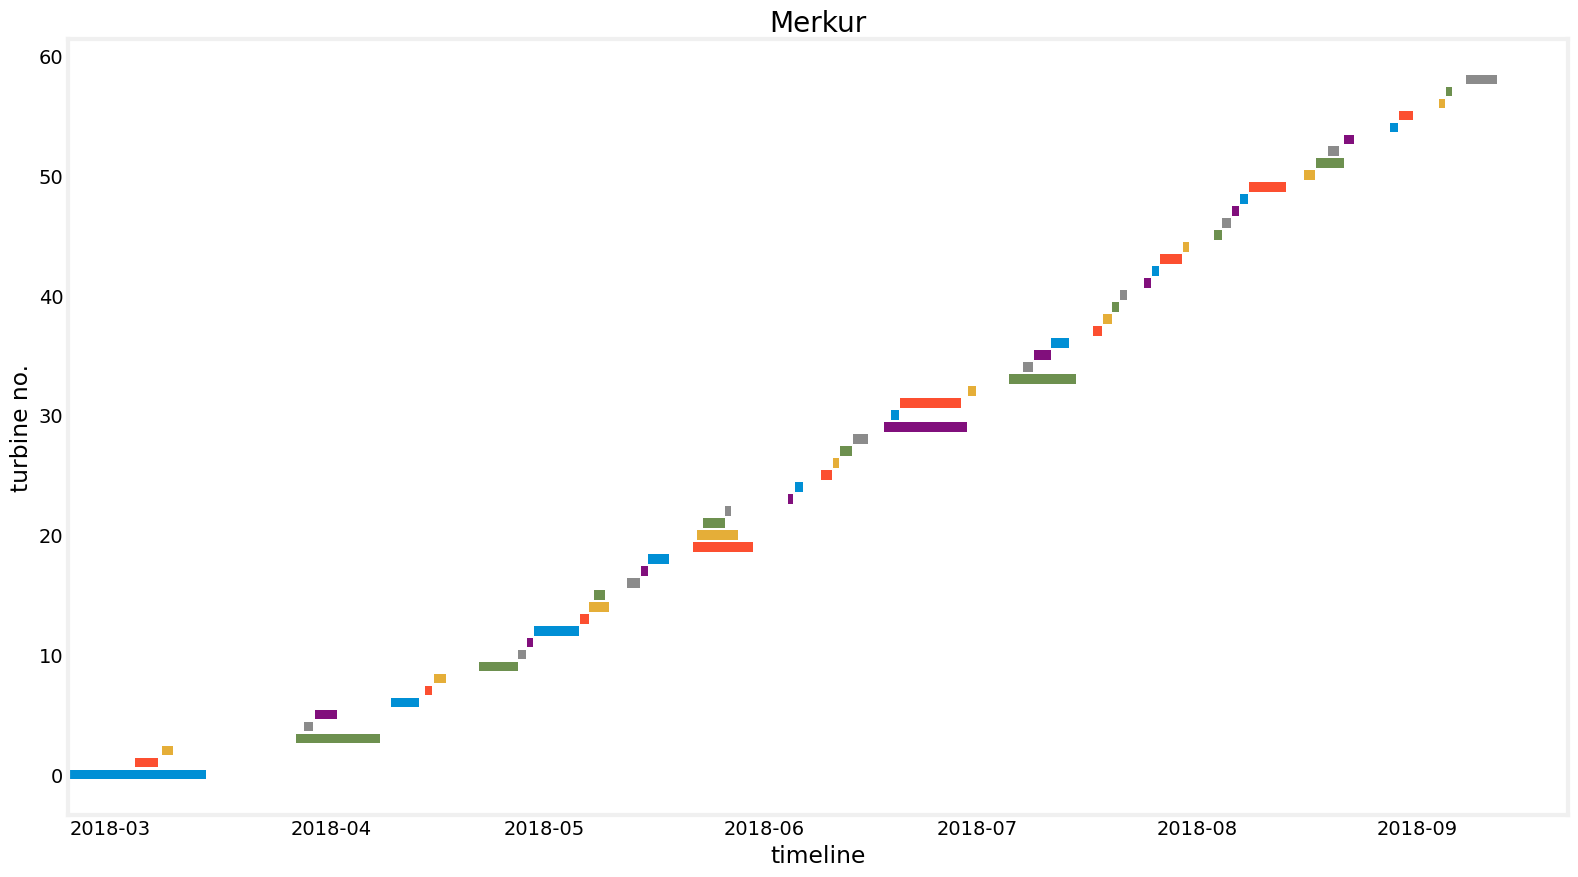

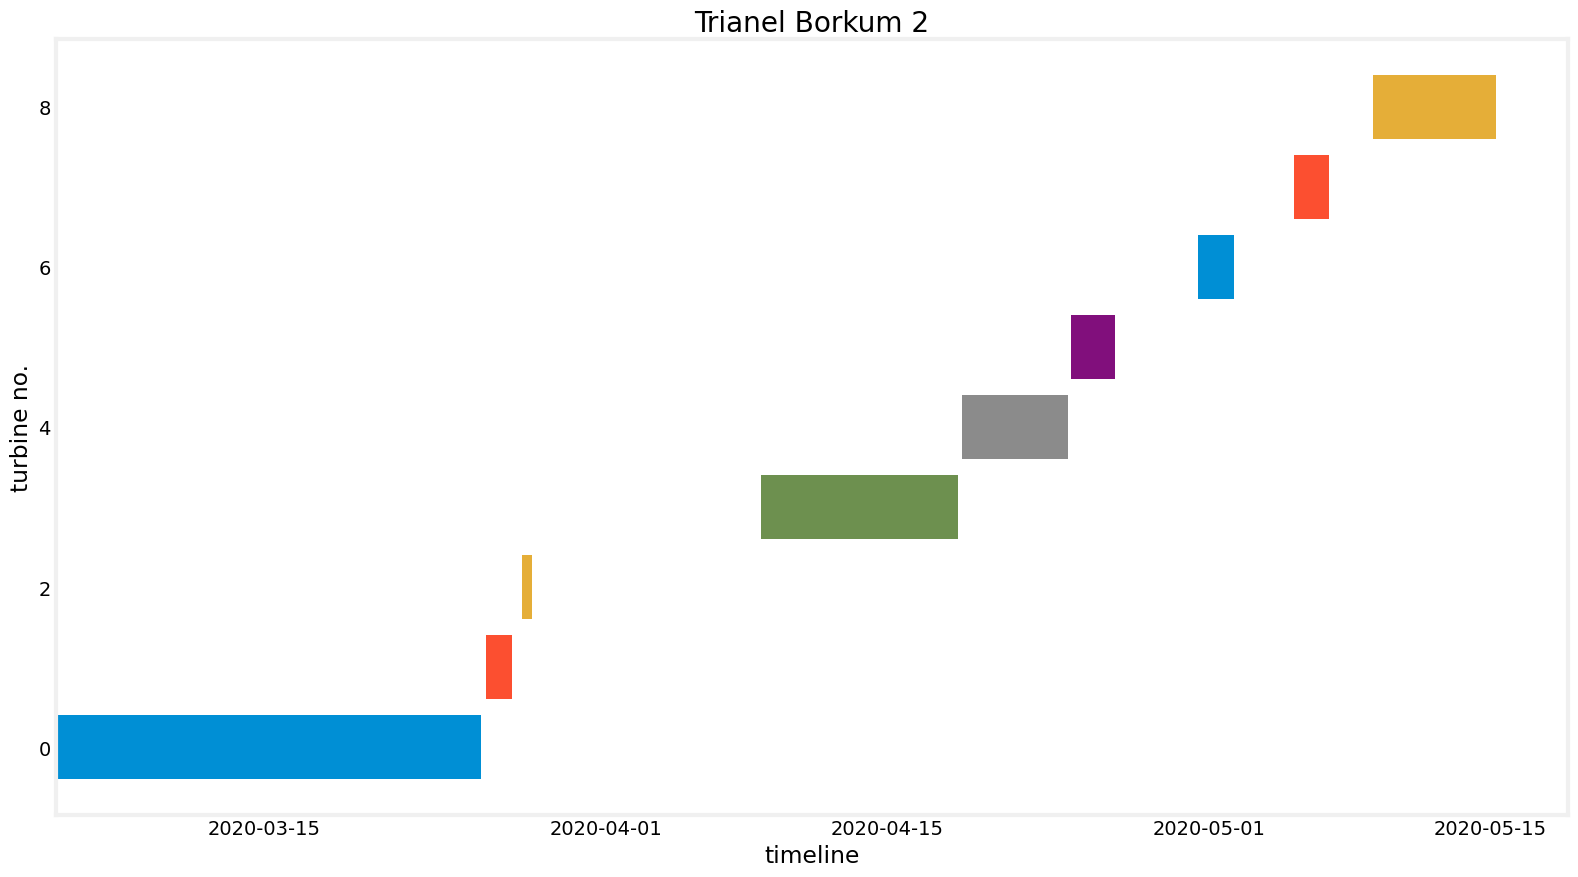

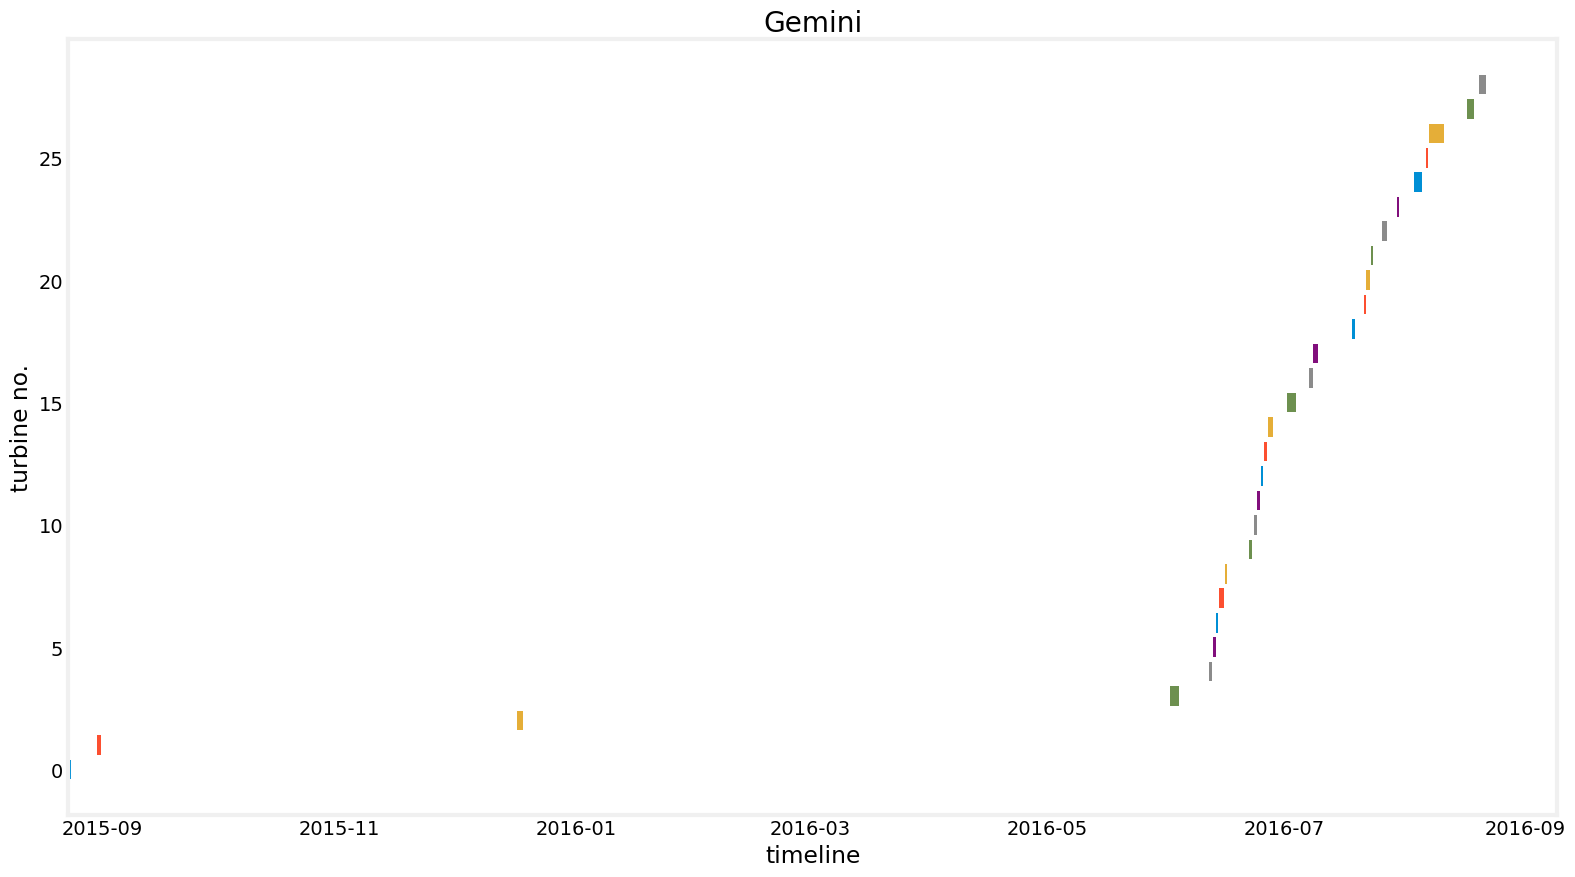

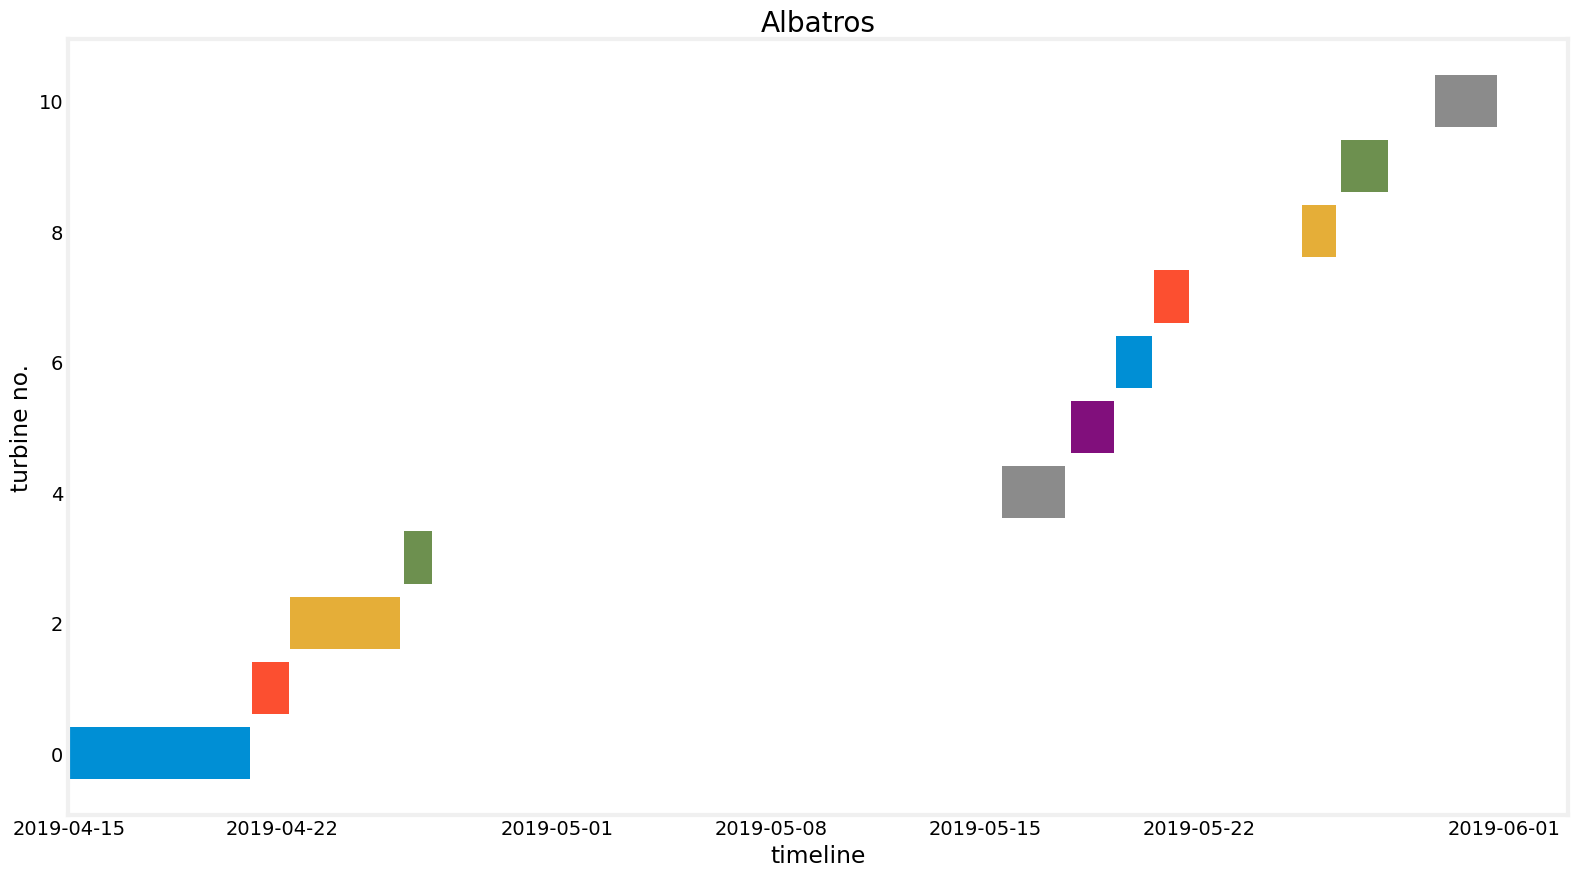

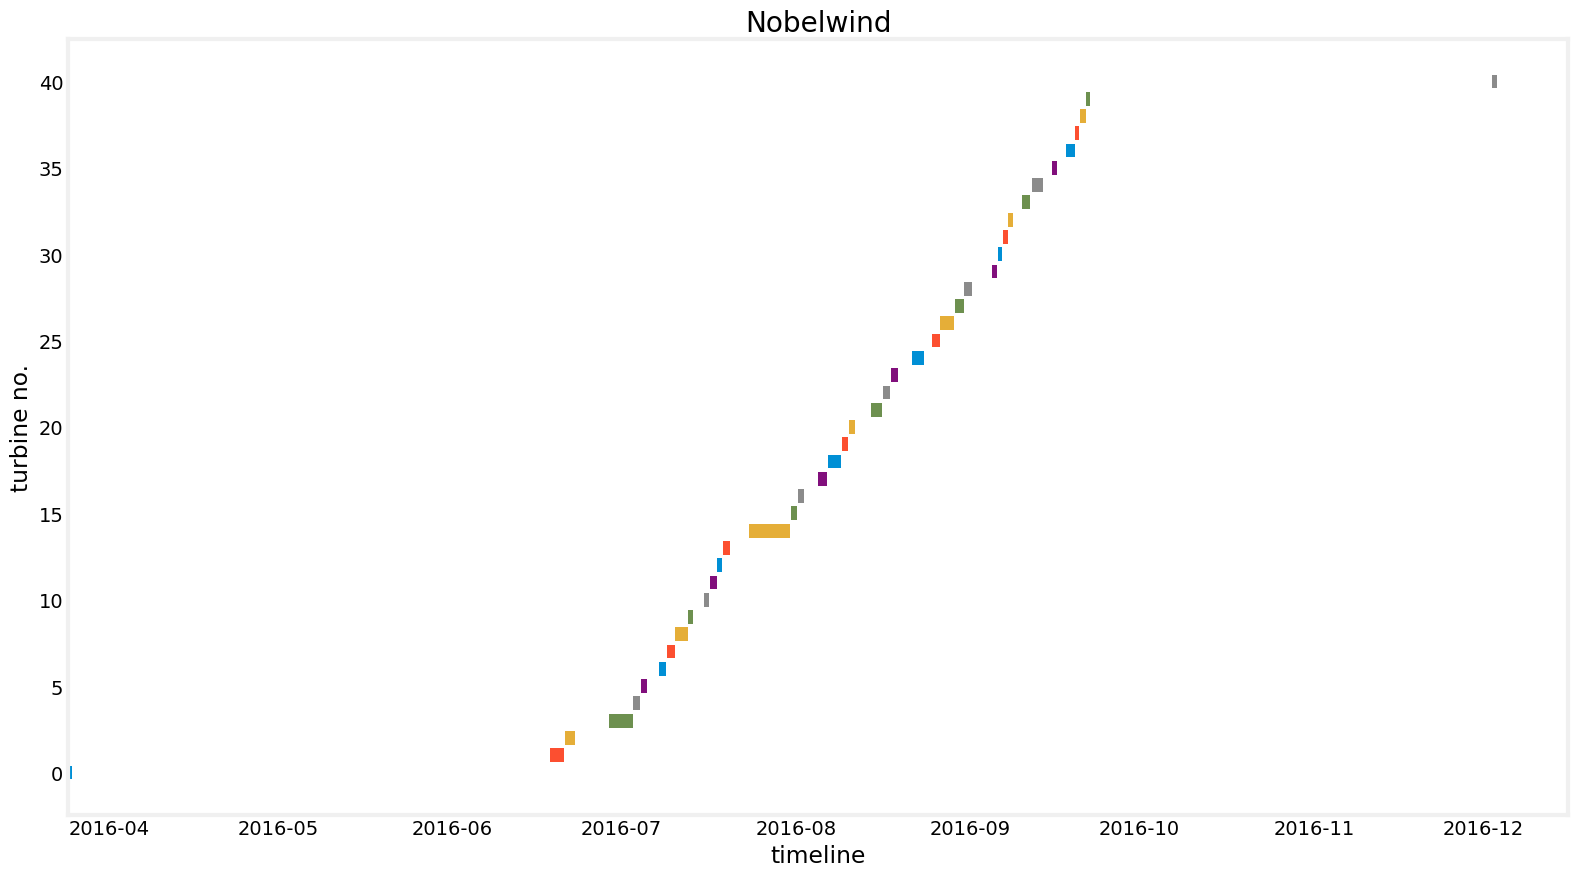

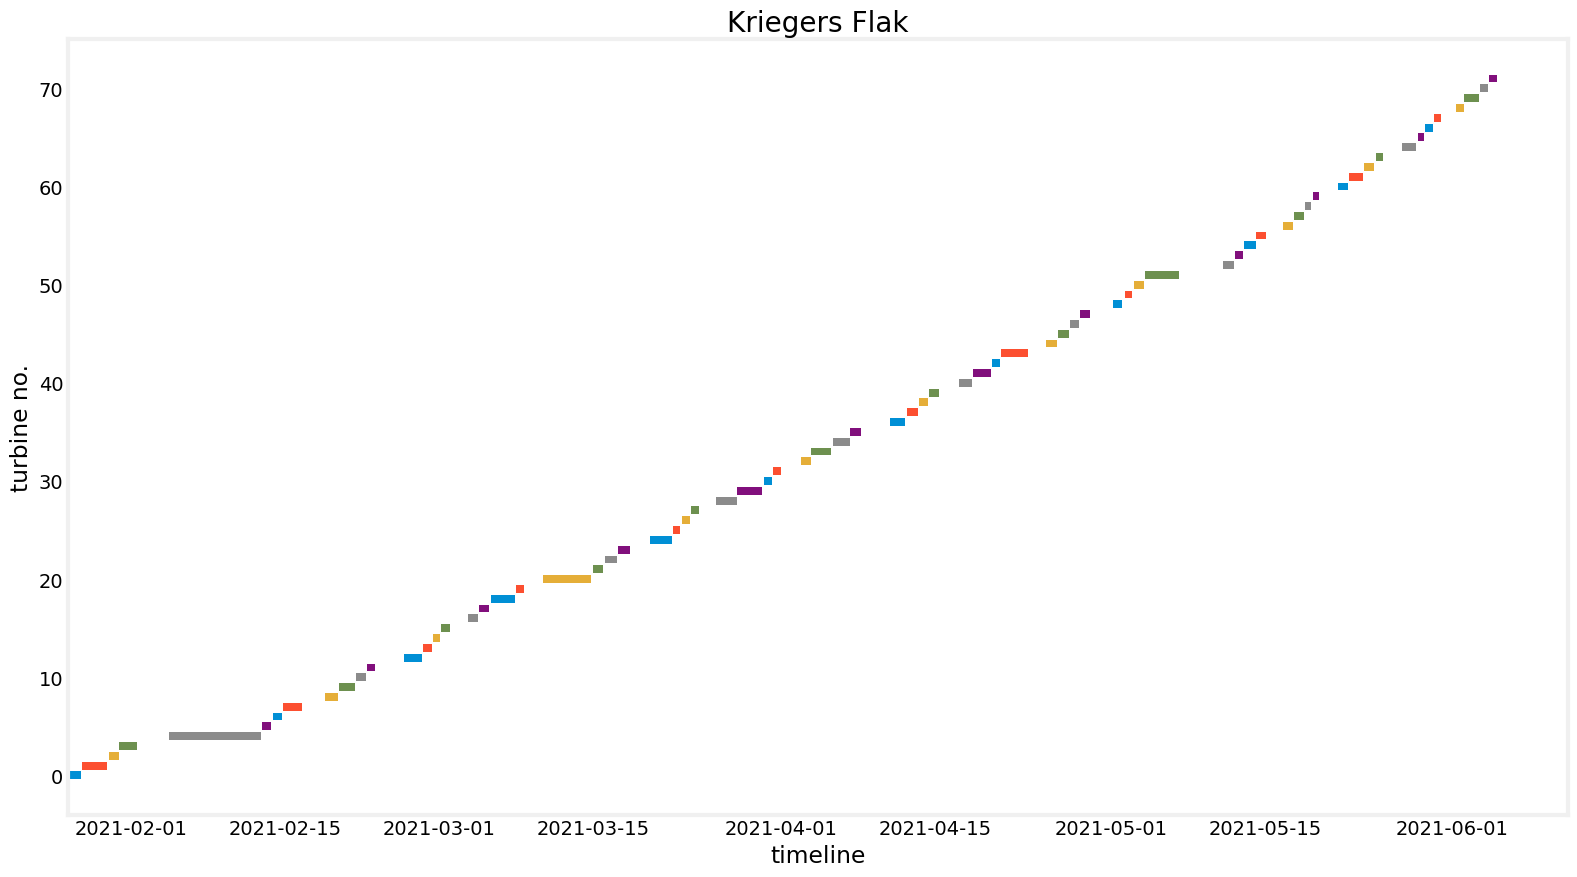

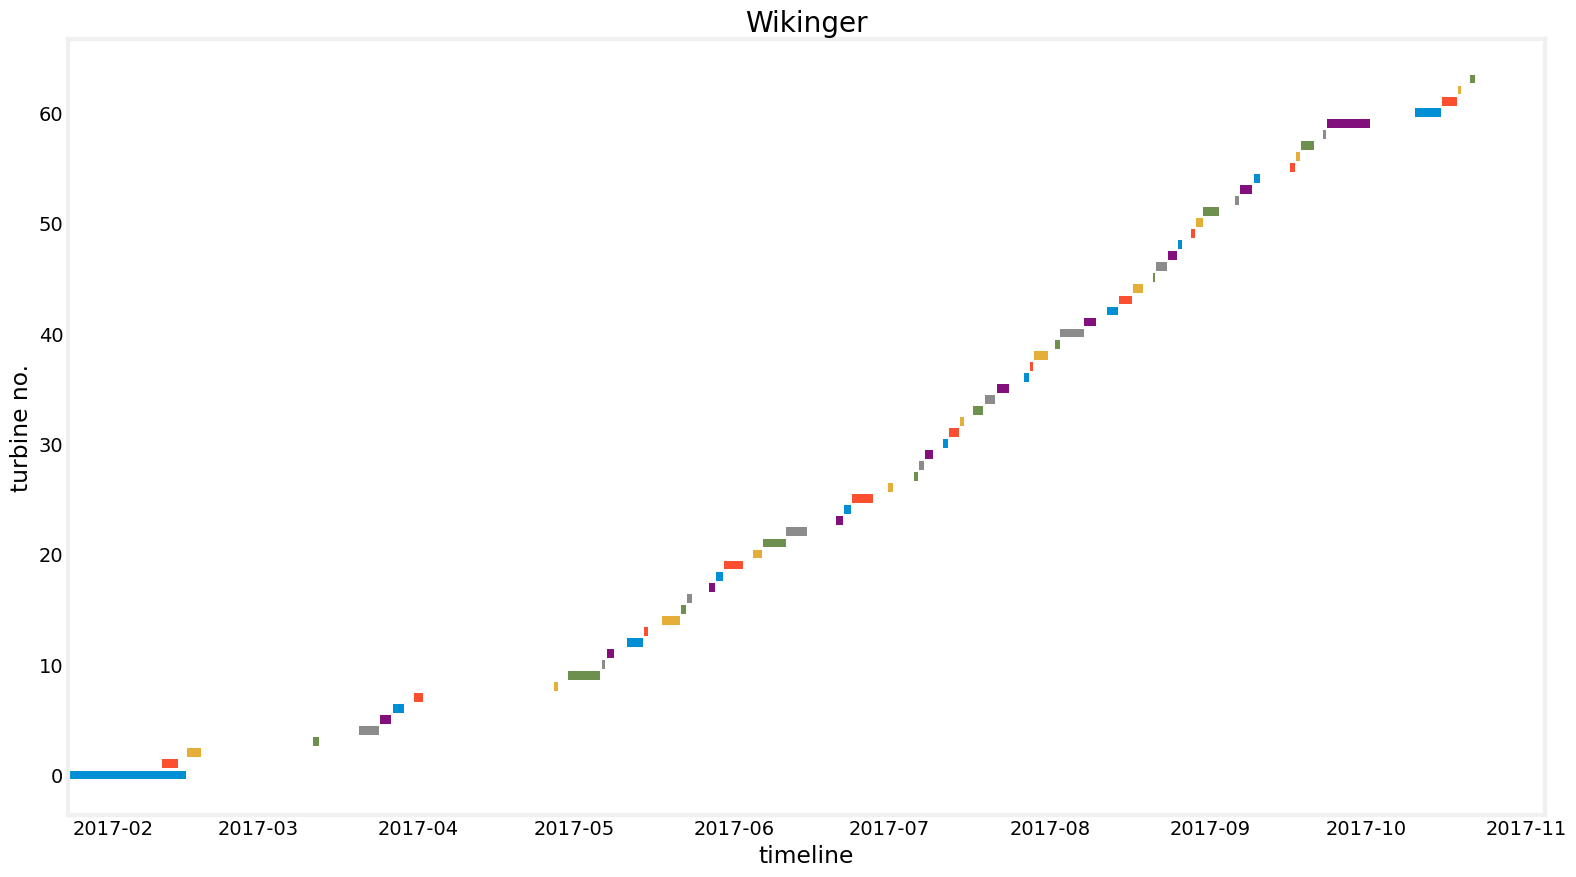

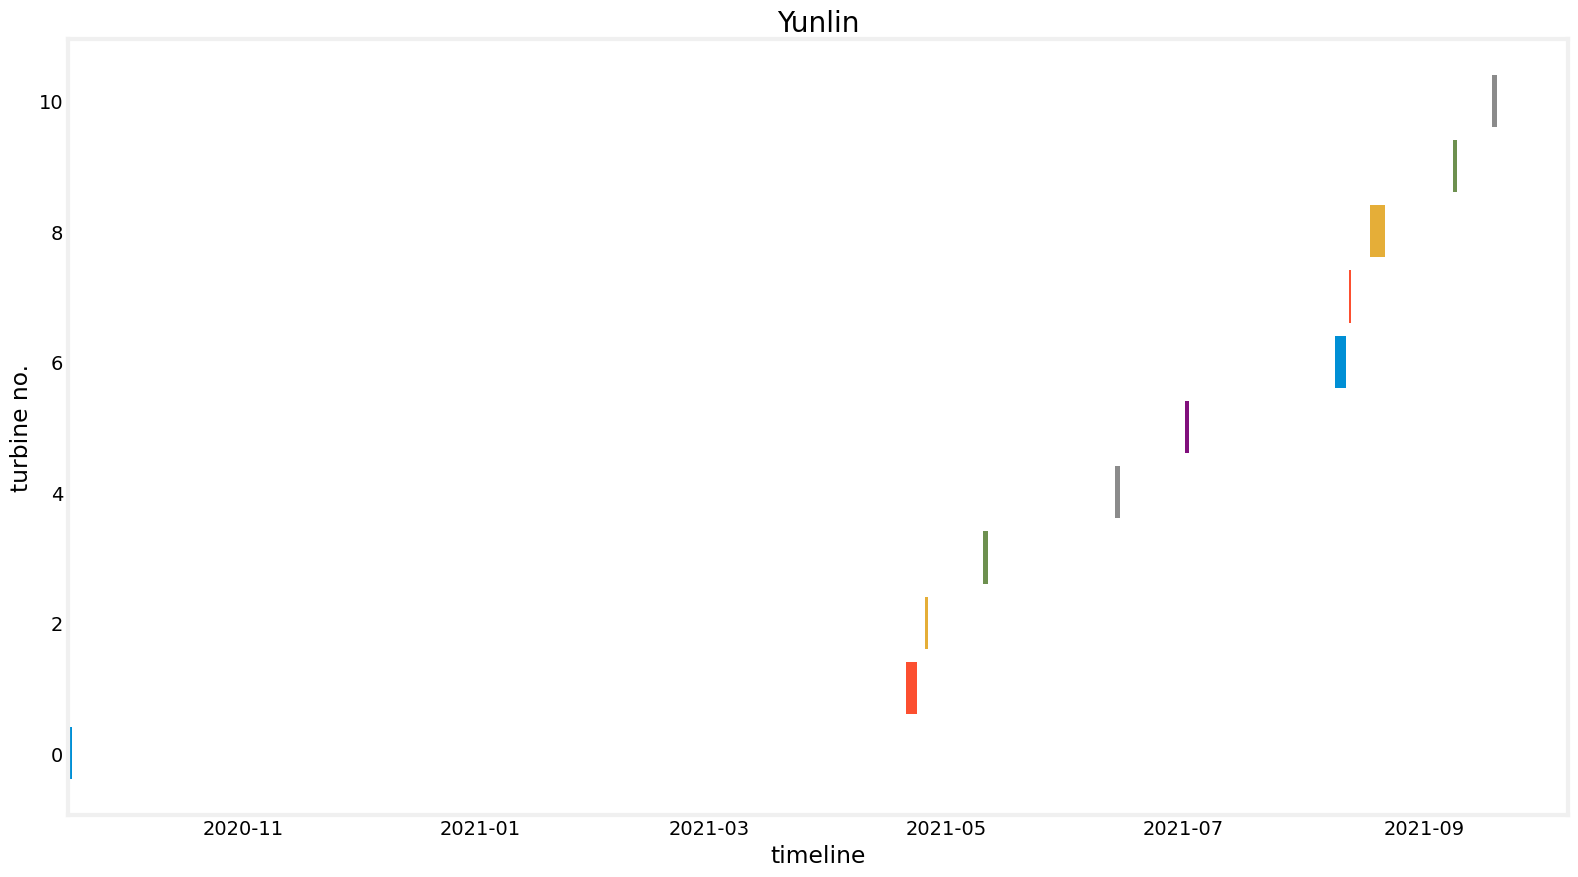

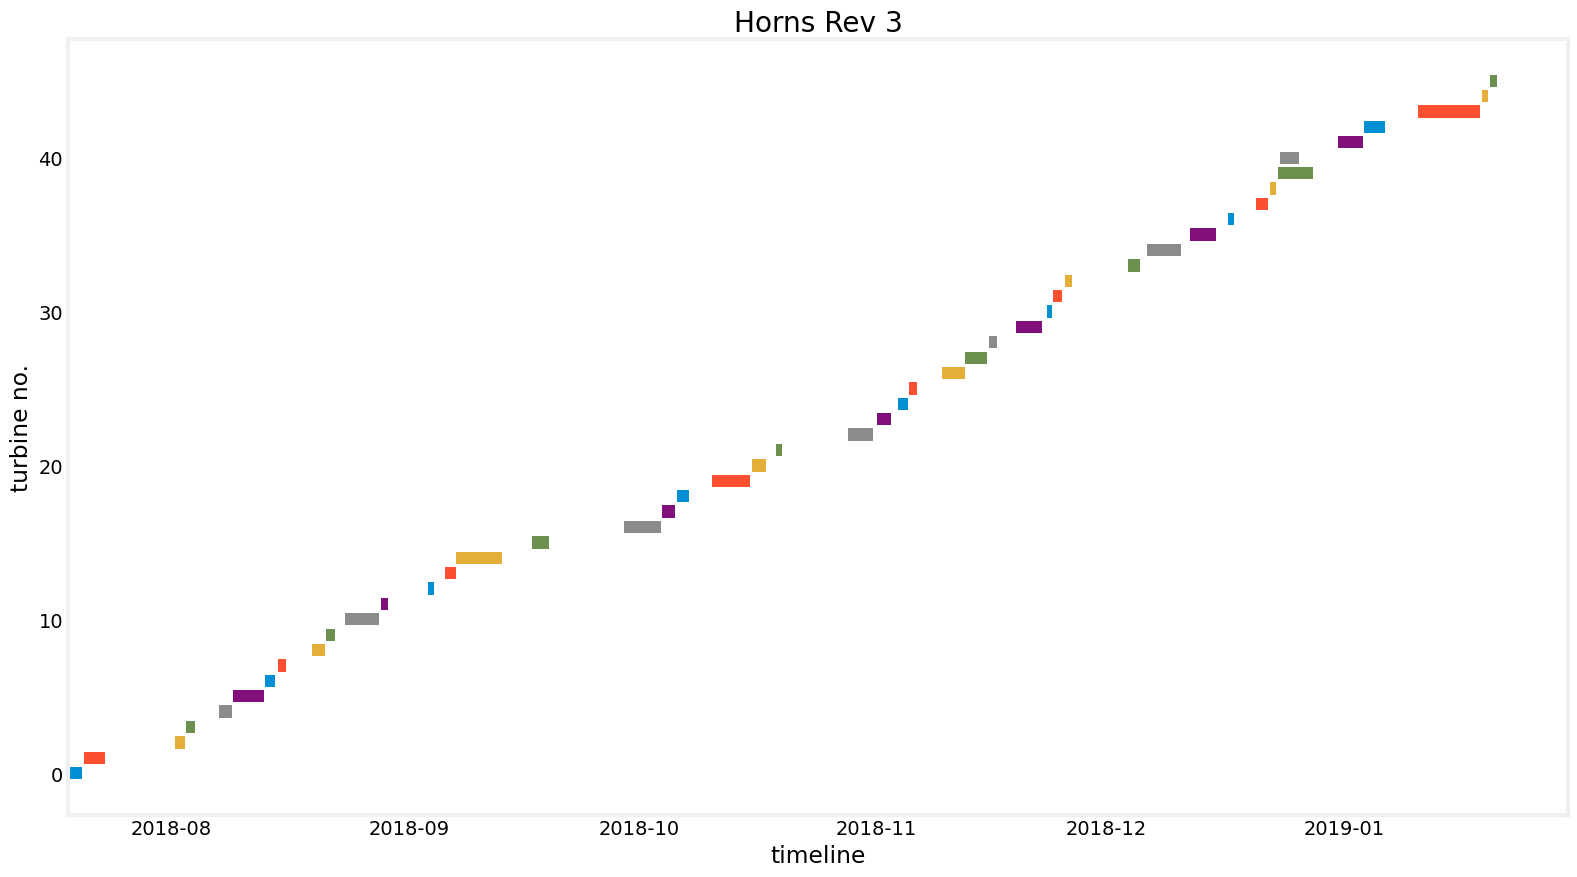

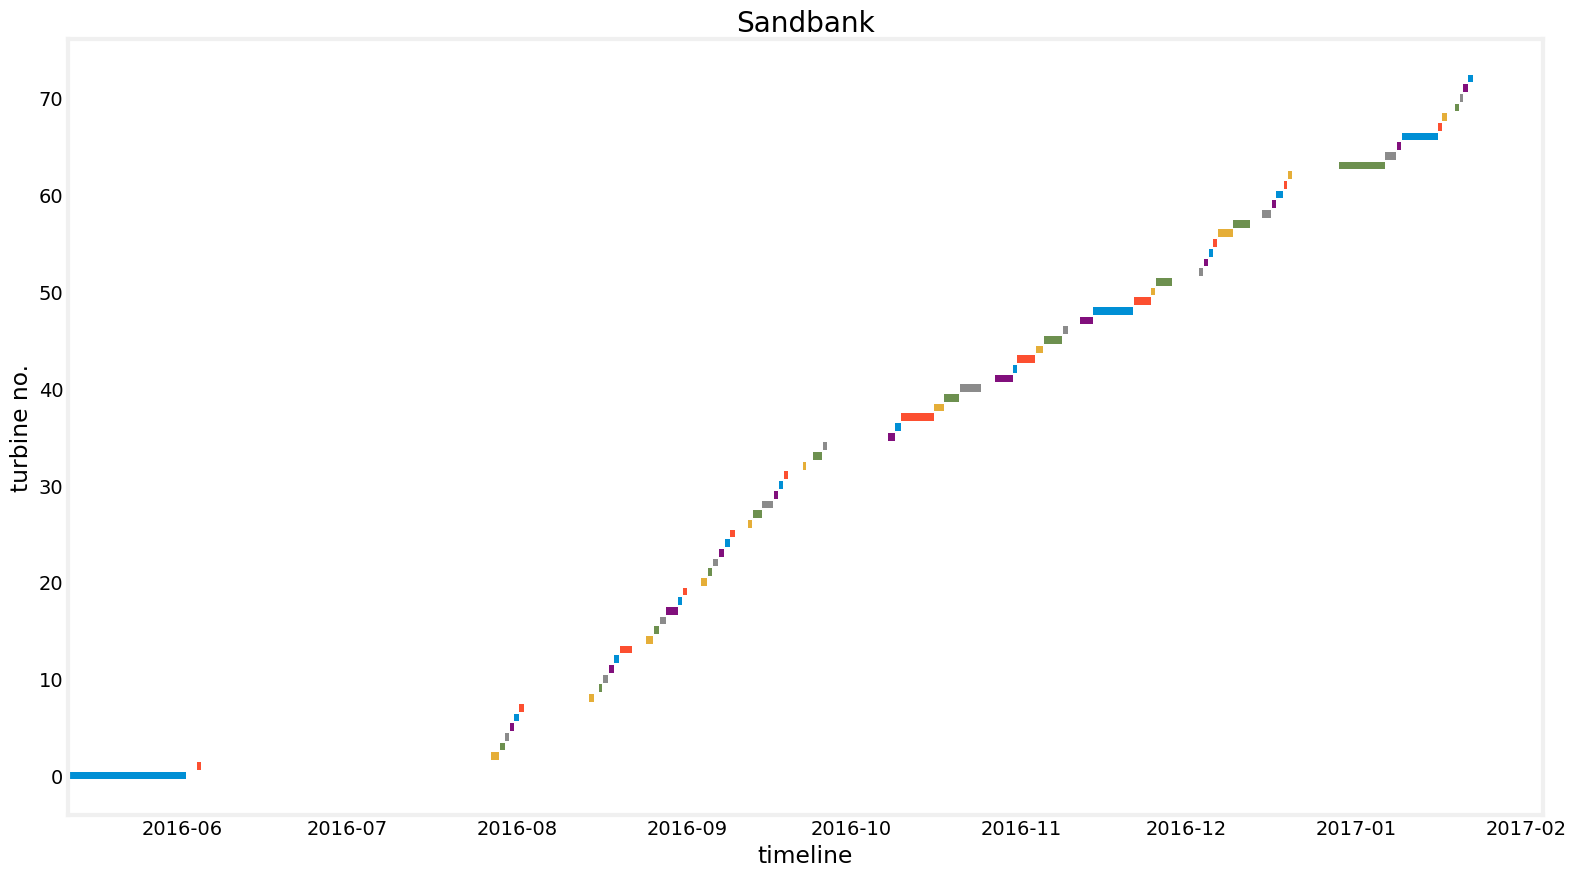

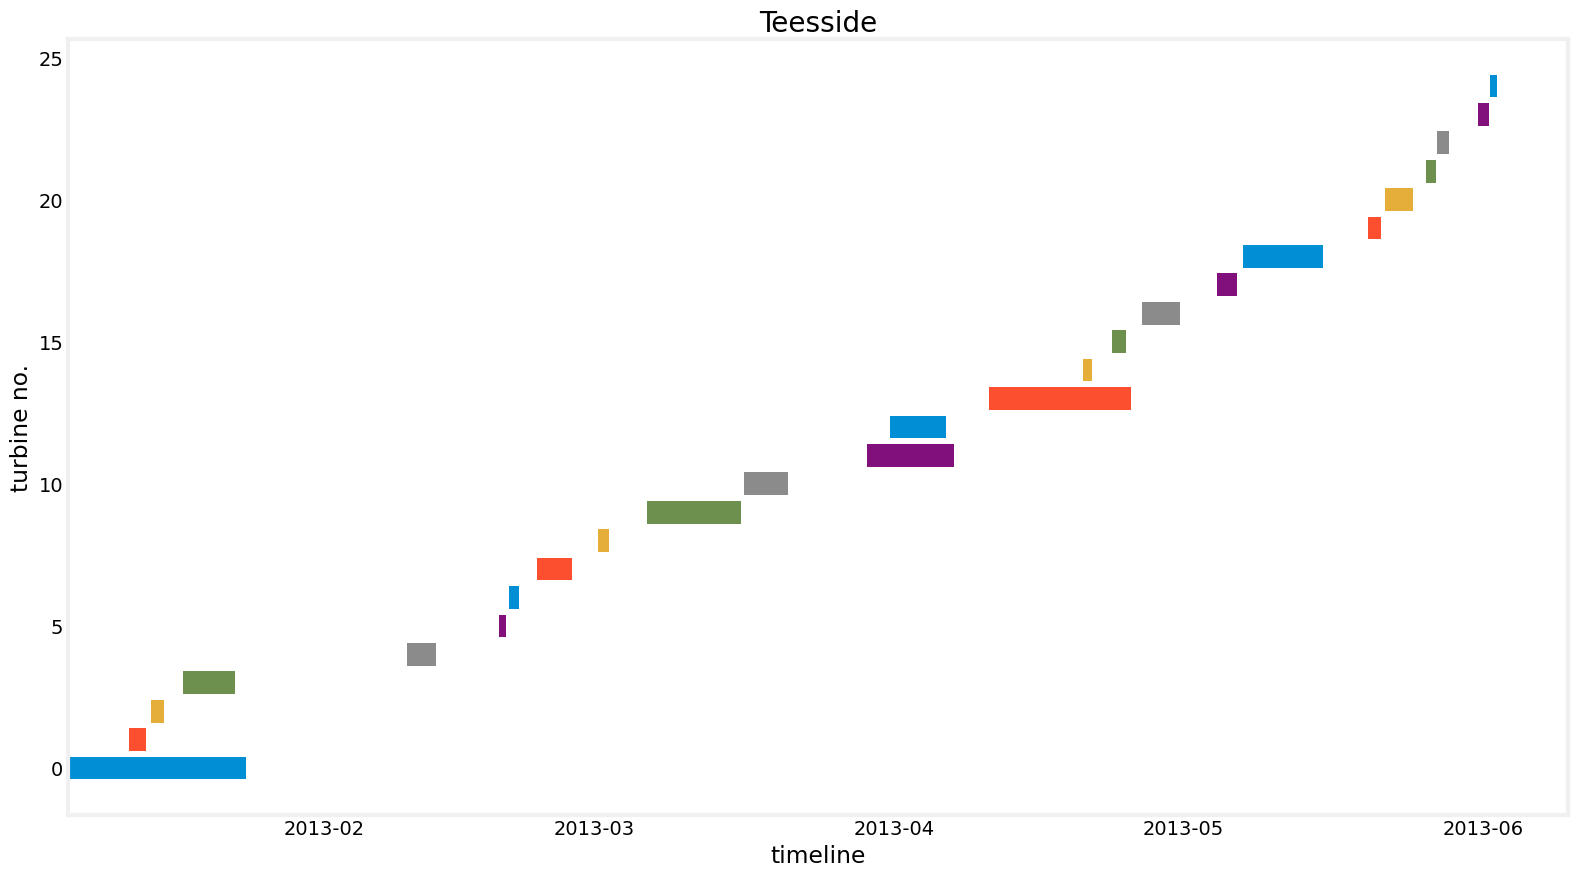

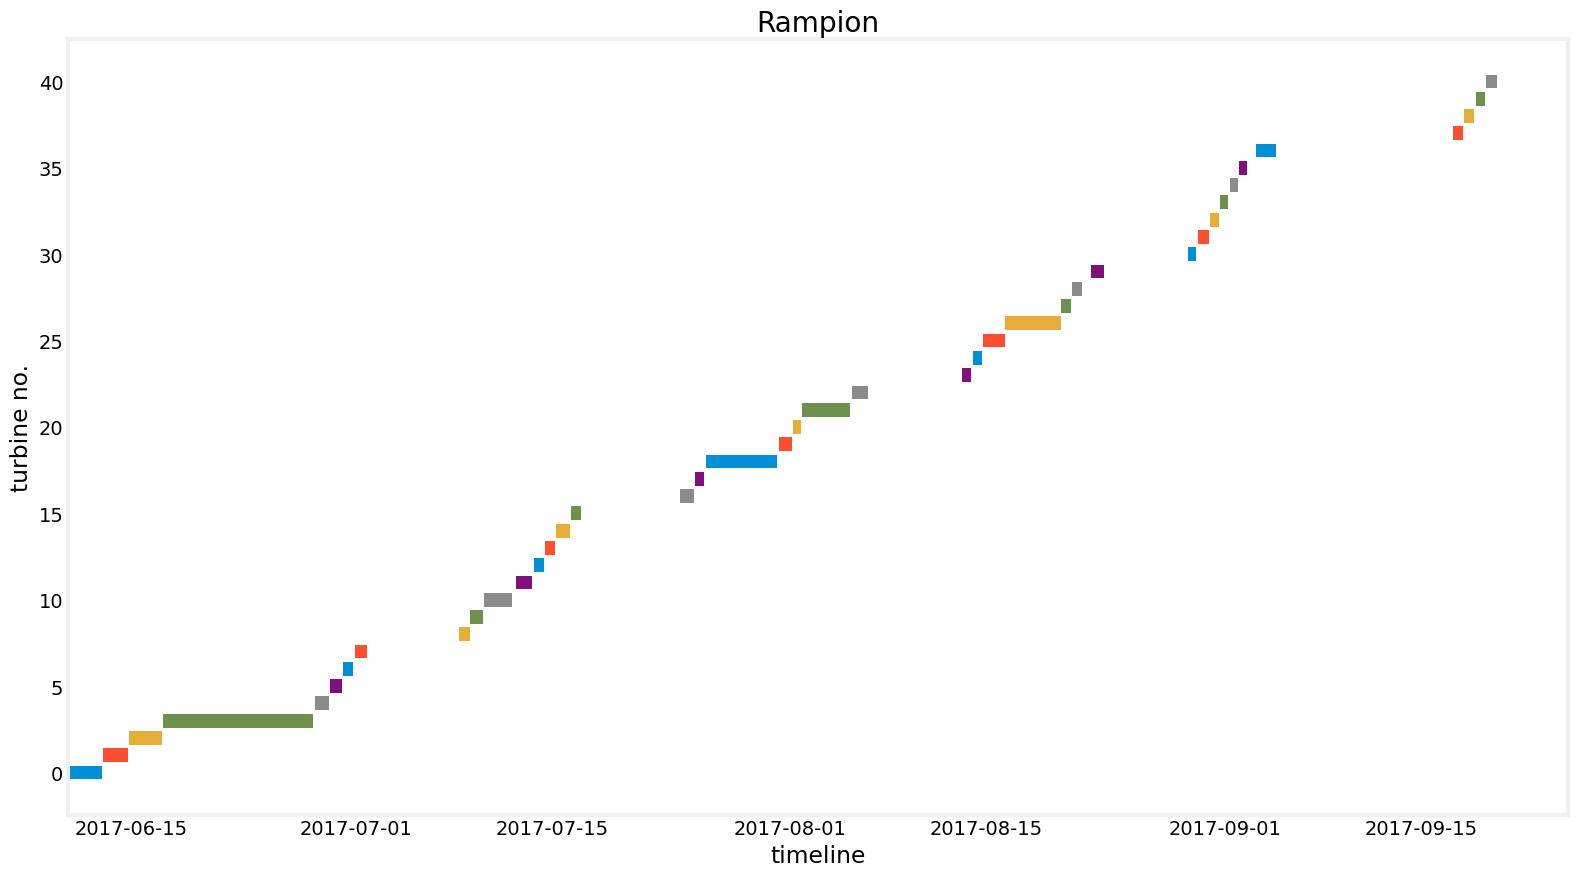

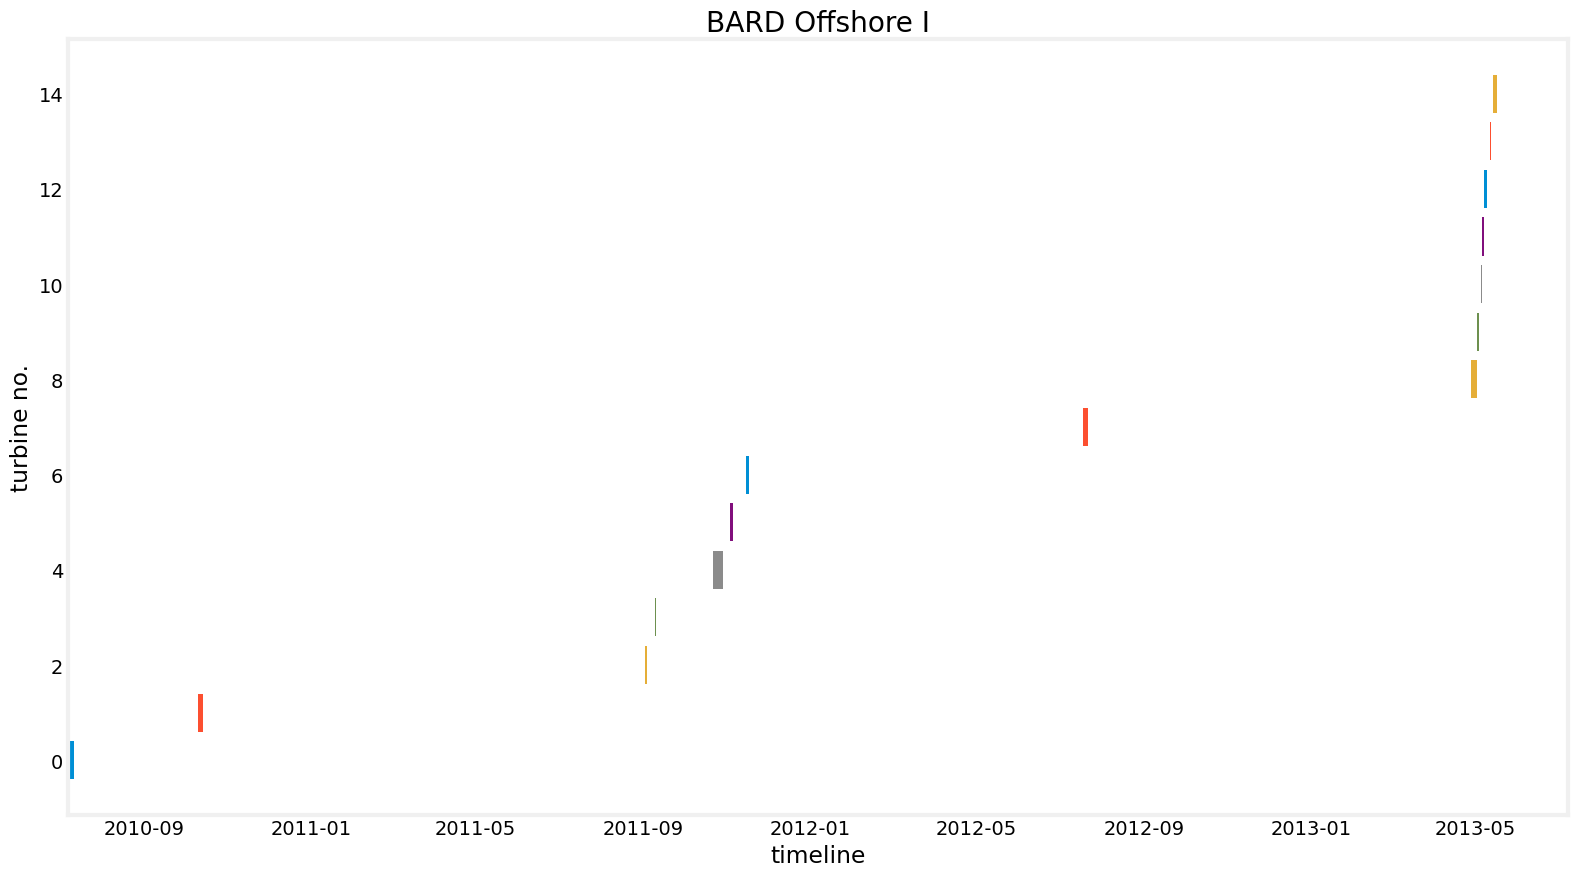

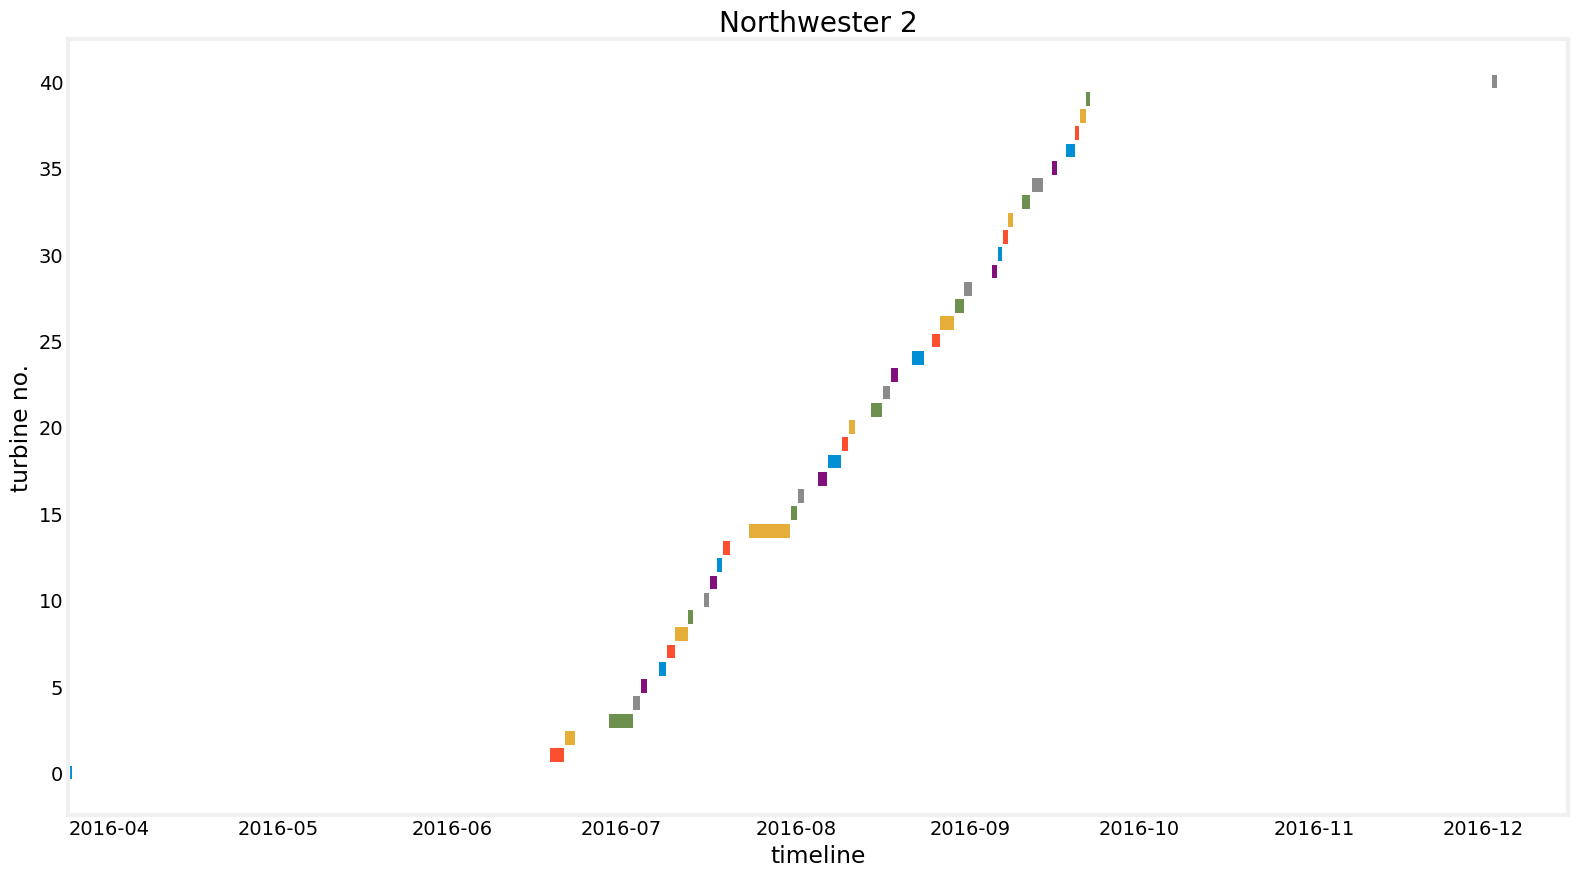

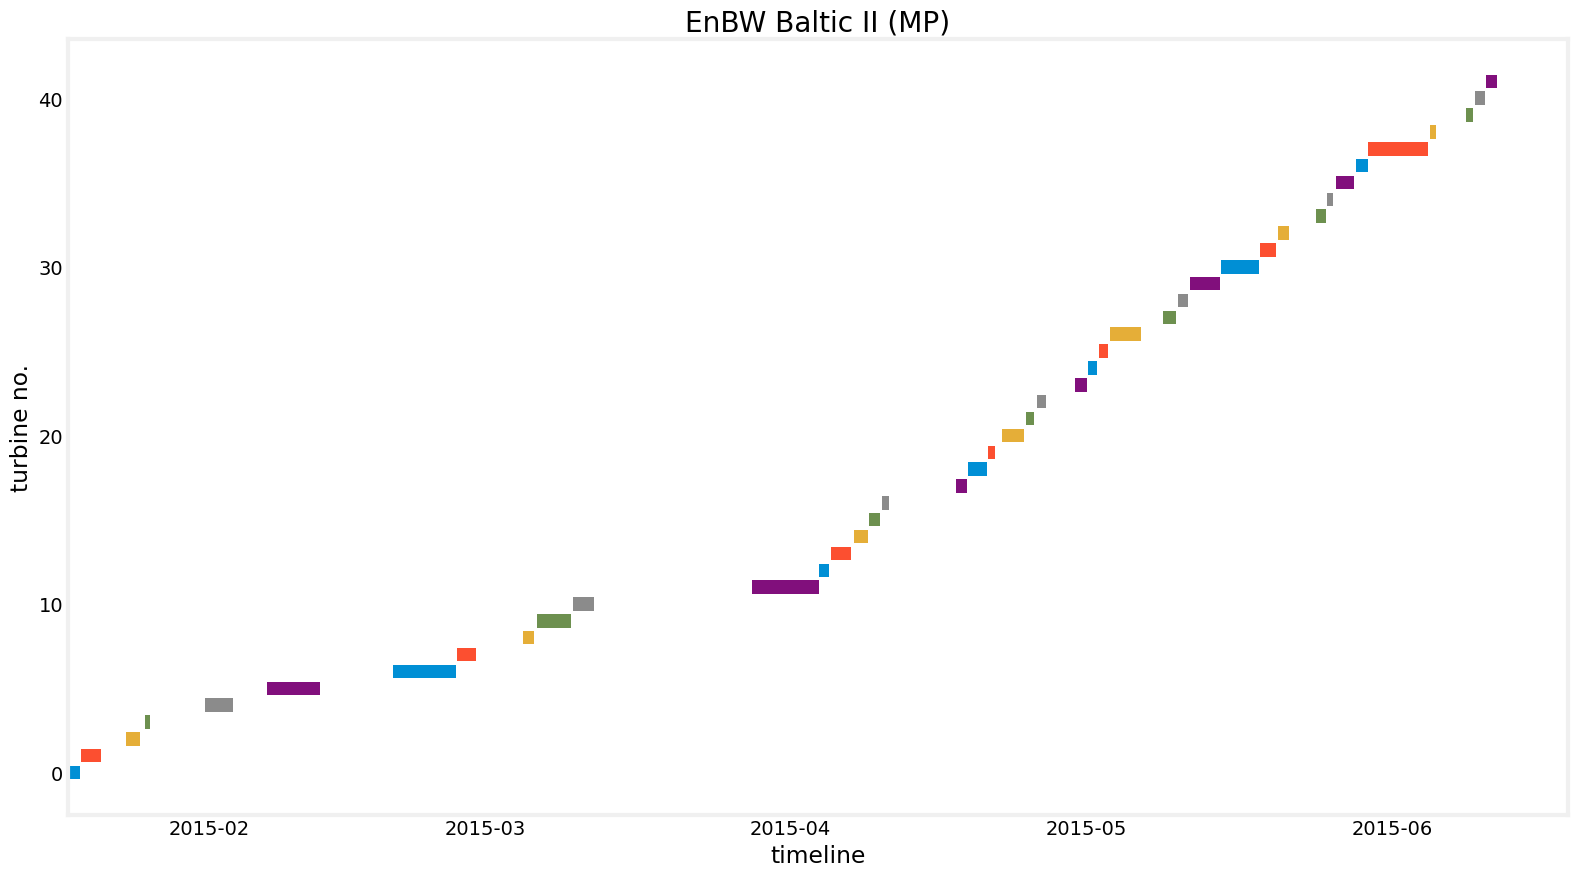

In [28]:
for key, windfarm in installations.items():
    plot_gantt(windfarm, title=windfarm_database.loc[key]['name'], save_fig=f"../manuscript/figures/gantt/{windfarm_database.loc[key]['name'].replace('/', '-')}.png")